<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/Tensorflow/basics1/malariaPredictionmbubesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input
from keras.src.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [80]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

In [81]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [82]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_testdataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_testdataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_testdataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [83]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [84]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# Data visualizaion

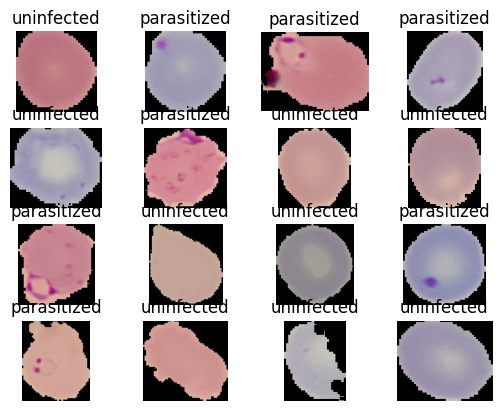

In [85]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# IMAGE PROCESSING

In [86]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [87]:
original_image, label = next(iter(train_dataset))

In [88]:
augmented_image = tf.image.flip_left_right(original_image)

In [89]:
augmented_image2 = tf.image.random_flip_up_down(original_image)

In [90]:
augmented_image3 = tf.image.rot90(original_image)

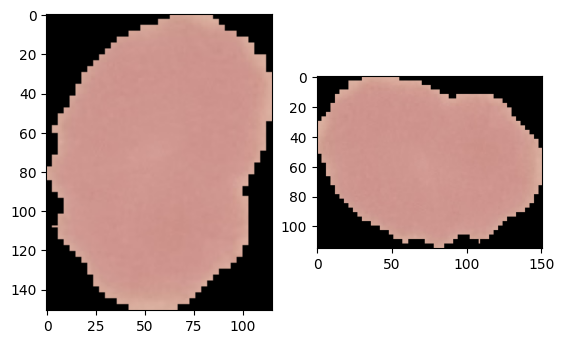

In [91]:
visualize(original_image, augmented_image3)

# Data Processing

In [92]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [93]:
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)
  # image = tf.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)
  return image, label

In [94]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(augment)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
    )

In [95]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(resize_rescale)
    .batch(32).prefetch(tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [96]:
train_dataset = train_dataset.map(augment)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [97]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

# Model creation

In [98]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(1000, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(100, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

# Functional API

In [99]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64    

In [100]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_22 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_23 (Ba  (None, 109, 109, 16)

In [101]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_15 (Dense)            (None, 1000)              46657000  
                                                                 
 batch_normalization_24 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 100)               100100

# Model Subclassing

In [102]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

# Metrics

In [103]:
metrics = [BinaryAccuracy(name="accuracy"), TruePositives(name='tp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           FalsePositives(name='fp'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# CallBacks

In [104]:
# Callback
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [105]:
# CSVLogger
csvlogger = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [106]:
# EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [107]:
# Learning rate schedular
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrSchedular = LearningRateScheduler(scheduler, verbose=1)

In [108]:
# Model checkpointing
checkPoint = ModelCheckpoint(
    'checkpoint/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq=3,
)

In [109]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)

# Training

In [110]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1,
                    callbacks=[csvlogger, earlystopping, lrSchedular, checkPoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  2/689 [..............................] - ETA: 1:22 - loss: 1.6592 - accuracy: 0.6250 - tp: 21.0000 - tn: 19.0000 - fn: 11.0000 - fp: 13.0000 - precision: 0.6176 - recall: 0.6562 - auc: 0.6333

  5/689 [..............................] - ETA: 1:17 - loss: 1.3558 - accuracy: 0.5688 - tp: 46.0000 - tn: 45.0000 - fn: 39.0000 - fp: 30.0000 - precision: 0.6053 - recall: 0.5412 - auc: 0.5820

  8/689 [..............................] - ETA: 1:15 - loss: 1.2060 - accuracy: 0.5508 - tp: 75.0000 - tn: 66.0000 - fn: 61.0000 - fp: 54.0000 - precision: 0.5814 - recall: 0.5515 - auc: 0.5513

 11/689 [..............................] - ETA: 1:41 - loss: 1.0732 - accuracy: 0.5625 - tp: 101.0000 - tn: 97.0000 - fn: 83.0000 - fp: 71.0000 - precision: 0.5872 - recall: 0.5489 - auc: 0.5657

 14/689 [..............................] - ETA: 1:40 - loss: 0.9842 - accuracy: 0.5893 - tp: 145.0000 - tn: 119.0000 - fn: 97.0000 - fp: 87.0000 - precision: 0.6250 - recall: 0.5992 - auc: 0.5827

 17/689 [..............................] - ETA: 1:48 - loss: 0.9297 - accuracy: 0.5993 - tp: 176.0000 - tn: 150.0000 - fn: 107.0000 - fp: 111.0000 - precision: 0.6132 - recall: 0.6219 - auc: 0.5946

 20/689 [..............................] - ETA: 1:55 - loss: 0.8939 - accuracy: 0.6016 - tp: 204.0000 - tn: 181.0000 - fn: 121.0000 - fp: 134.0000 - precision: 0.6036 - recall: 0.6277 - auc: 0.5978

 23/689 [>.............................] - ETA: 1:51 - loss: 0.8551 - accuracy: 0.6196 - tp: 246.0000 - tn: 210.0000 - fn: 129.0000 - fp: 151.0000 - precision: 0.6196 - recall: 0.6560 - auc: 0.6120

 26/689 [>.............................] - ETA: 1:53 - loss: 0.8335 - accuracy: 0.6178 - tp: 279.0000 - tn: 235.0000 - fn: 142.0000 - fp: 176.0000 - precision: 0.6132 - recall: 0.6627 - auc: 0.6147

 29/689 [>.............................] - ETA: 1:47 - loss: 0.8198 - accuracy: 0.6164 - tp: 317.0000 - tn: 255.0000 - fn: 155.0000 - fp: 201.0000 - precision: 0.6120 - recall: 0.6716 - auc: 0.6115

 32/689 [>.............................] - ETA: 1:45 - loss: 0.8021 - accuracy: 0.6230 - tp: 357.0000 - tn: 281.0000 - fn: 168.0000 - fp: 218.0000 - precision: 0.6209 - recall: 0.6800 - auc: 0.6161

 35/689 [>.............................] - ETA: 1:40 - loss: 0.7958 - accuracy: 0.6196 - tp: 389.0000 - tn: 305.0000 - fn: 186.0000 - fp: 240.0000 - precision: 0.6184 - recall: 0.6765 - auc: 0.6135

 38/689 [>.............................] - ETA: 1:38 - loss: 0.7847 - accuracy: 0.6225 - tp: 431.0000 - tn: 326.0000 - fn: 205.0000 - fp: 254.0000 - precision: 0.6292 - recall: 0.6777 - auc: 0.6148

 41/689 [>.............................] - ETA: 1:34 - loss: 0.7780 - accuracy: 0.6204 - tp: 470.0000 - tn: 344.0000 - fn: 219.0000 - fp: 279.0000 - precision: 0.6275 - recall: 0.6821 - auc: 0.6132

 44/689 [>.............................] - ETA: 1:33 - loss: 0.7679 - accuracy: 0.6236 - tp: 510.0000 - tn: 368.0000 - fn: 228.0000 - fp: 302.0000 - precision: 0.6281 - recall: 0.6911 - auc: 0.6177

 47/689 [=>............................] - ETA: 1:32 - loss: 0.7621 - accuracy: 0.6217 - tp: 546.0000 - tn: 389.0000 - fn: 239.0000 - fp: 330.0000 - precision: 0.6233 - recall: 0.6955 - auc: 0.6174

 50/689 [=>............................] - ETA: 1:31 - loss: 0.7568 - accuracy: 0.6212 - tp: 584.0000 - tn: 410.0000 - fn: 253.0000 - fp: 353.0000 - precision: 0.6233 - recall: 0.6977 - auc: 0.6187

 53/689 [=>............................] - ETA: 1:29 - loss: 0.7519 - accuracy: 0.6197 - tp: 622.0000 - tn: 429.0000 - fn: 266.0000 - fp: 379.0000 - precision: 0.6214 - recall: 0.7005 - auc: 0.6202

 56/689 [=>............................] - ETA: 1:28 - loss: 0.7577 - accuracy: 0.6122 - tp: 649.0000 - tn: 448.0000 - fn: 287.0000 - fp: 408.0000 - precision: 0.6140 - recall: 0.6934 - auc: 0.6100

 59/689 [=>............................] - ETA: 1:25 - loss: 0.7513 - accuracy: 0.6123 - tp: 682.0000 - tn: 474.0000 - fn: 295.0000 - fp: 437.0000 - precision: 0.6095 - recall: 0.6981 - auc: 0.6146

 62/689 [=>............................] - ETA: 1:24 - loss: 0.7492 - accuracy: 0.6074 - tp: 714.0000 - tn: 491.0000 - fn: 310.0000 - fp: 469.0000 - precision: 0.6036 - recall: 0.6973 - auc: 0.6139

 65/689 [=>............................] - ETA: 1:23 - loss: 0.7434 - accuracy: 0.6096 - tp: 750.0000 - tn: 518.0000 - fn: 328.0000 - fp: 484.0000 - precision: 0.6078 - recall: 0.6957 - auc: 0.6172

 68/689 [=>............................] - ETA: 1:23 - loss: 0.7383 - accuracy: 0.6103 - tp: 781.0000 - tn: 547.0000 - fn: 348.0000 - fp: 500.0000 - precision: 0.6097 - recall: 0.6918 - auc: 0.6206

 71/689 [==>...........................] - ETA: 1:22 - loss: 0.7364 - accuracy: 0.6083 - tp: 815.0000 - tn: 567.0000 - fn: 366.0000 - fp: 524.0000 - precision: 0.6087 - recall: 0.6901 - auc: 0.6221

 74/689 [==>...........................] - ETA: 1:20 - loss: 0.7366 - accuracy: 0.6081 - tp: 855.0000 - tn: 585.0000 - fn: 377.0000 - fp: 551.0000 - precision: 0.6081 - recall: 0.6940 - auc: 0.6217

 77/689 [==>...........................] - ETA: 1:20 - loss: 0.7354 - accuracy: 0.6051 - tp: 882.0000 - tn: 609.0000 - fn: 399.0000 - fp: 574.0000 - precision: 0.6058 - recall: 0.6885 - auc: 0.6202

 80/689 [==>...........................] - ETA: 1:18 - loss: 0.7347 - accuracy: 0.6027 - tp: 908.0000 - tn: 635.0000 - fn: 425.0000 - fp: 592.0000 - precision: 0.6053 - recall: 0.6812 - auc: 0.6181

 83/689 [==>...........................] - ETA: 1:18 - loss: 0.7342 - accuracy: 0.6020 - tp: 934.0000 - tn: 665.0000 - fn: 449.0000 - fp: 608.0000 - precision: 0.6057 - recall: 0.6753 - auc: 0.6158

 86/689 [==>...........................] - ETA: 1:17 - loss: 0.7329 - accuracy: 0.6014 - tp: 963.0000 - tn: 692.0000 - fn: 463.0000 - fp: 634.0000 - precision: 0.6030 - recall: 0.6753 - auc: 0.6157

 89/689 [==>...........................] - ETA: 1:16 - loss: 0.7311 - accuracy: 0.6022 - tp: 1000.0000 - tn: 715.0000 - fn: 472.0000 - fp: 661.0000 - precision: 0.6020 - recall: 0.6793 - auc: 0.6167

 92/689 [===>..........................] - ETA: 1:15 - loss: 0.7298 - accuracy: 0.6005 - tp: 1031.0000 - tn: 737.0000 - fn: 482.0000 - fp: 694.0000 - precision: 0.5977 - recall: 0.6814 - auc: 0.6167

 95/689 [===>..........................] - ETA: 1:15 - loss: 0.7275 - accuracy: 0.6023 - tp: 1066.0000 - tn: 765.0000 - fn: 496.0000 - fp: 713.0000 - precision: 0.5992 - recall: 0.6825 - auc: 0.6174

 98/689 [===>..........................] - ETA: 1:14 - loss: 0.7265 - accuracy: 0.5995 - tp: 1092.0000 - tn: 788.0000 - fn: 513.0000 - fp: 743.0000 - precision: 0.5951 - recall: 0.6804 - auc: 0.6167

101/689 [===>..........................] - ETA: 1:14 - loss: 0.7249 - accuracy: 0.5981 - tp: 1118.0000 - tn: 815.0000 - fn: 535.0000 - fp: 764.0000 - precision: 0.5940 - recall: 0.6763 - auc: 0.6169

104/689 [===>..........................] - ETA: 1:13 - loss: 0.7230 - accuracy: 0.5986 - tp: 1143.0000 - tn: 849.0000 - fn: 551.0000 - fp: 785.0000 - precision: 0.5928 - recall: 0.6747 - auc: 0.6181

107/689 [===>..........................] - ETA: 1:12 - loss: 0.7211 - accuracy: 0.5981 - tp: 1171.0000 - tn: 877.0000 - fn: 569.0000 - fp: 807.0000 - precision: 0.5920 - recall: 0.6730 - auc: 0.6191

110/689 [===>..........................] - ETA: 1:12 - loss: 0.7194 - accuracy: 0.6003 - tp: 1206.0000 - tn: 907.0000 - fn: 583.0000 - fp: 824.0000 - precision: 0.5941 - recall: 0.6741 - auc: 0.6210

113/689 [===>..........................] - ETA: 1:11 - loss: 0.7185 - accuracy: 0.6001 - tp: 1239.0000 - tn: 931.0000 - fn: 597.0000 - fp: 849.0000 - precision: 0.5934 - recall: 0.6748 - auc: 0.6216

116/689 [====>.........................] - ETA: 1:11 - loss: 0.7159 - accuracy: 0.6029 - tp: 1270.0000 - tn: 968.0000 - fn: 614.0000 - fp: 860.0000 - precision: 0.5962 - recall: 0.6741 - auc: 0.6241

119/689 [====>.........................] - ETA: 1:10 - loss: 0.7142 - accuracy: 0.6045 - tp: 1295.0000 - tn: 1007.0000 - fn: 631.0000 - fp: 875.0000 - precision: 0.5968 - recall: 0.6724 - auc: 0.6252

122/689 [====>.........................] - ETA: 1:10 - loss: 0.7134 - accuracy: 0.6040 - tp: 1322.0000 - tn: 1036.0000 - fn: 655.0000 - fp: 891.0000 - precision: 0.5974 - recall: 0.6687 - auc: 0.6258

125/689 [====>.........................] - ETA: 1:09 - loss: 0.7117 - accuracy: 0.6050 - tp: 1348.0000 - tn: 1072.0000 - fn: 666.0000 - fp: 914.0000 - precision: 0.5959 - recall: 0.6693 - auc: 0.6270

128/689 [====>.........................] - ETA: 1:09 - loss: 0.7103 - accuracy: 0.6042 - tp: 1376.0000 - tn: 1099.0000 - fn: 684.0000 - fp: 937.0000 - precision: 0.5949 - recall: 0.6680 - auc: 0.6275

131/689 [====>.........................] - ETA: 1:10 - loss: 0.7086 - accuracy: 0.6052 - tp: 1415.0000 - tn: 1122.0000 - fn: 698.0000 - fp: 957.0000 - precision: 0.5965 - recall: 0.6697 - auc: 0.6294

134/689 [====>.........................] - ETA: 1:11 - loss: 0.7079 - accuracy: 0.6056 - tp: 1446.0000 - tn: 1151.0000 - fn: 707.0000 - fp: 984.0000 - precision: 0.5951 - recall: 0.6716 - auc: 0.6295

137/689 [====>.........................] - ETA: 1:11 - loss: 0.7081 - accuracy: 0.6047 - tp: 1475.0000 - tn: 1176.0000 - fn: 732.0000 - fp: 1001.0000 - precision: 0.5957 - recall: 0.6683 - auc: 0.6278

140/689 [=====>........................] - ETA: 1:11 - loss: 0.7083 - accuracy: 0.6020 - tp: 1487.0000 - tn: 1210.0000 - fn: 773.0000 - fp: 1010.0000 - precision: 0.5955 - recall: 0.6580 - auc: 0.6257

143/689 [=====>........................] - ETA: 1:11 - loss: 0.7084 - accuracy: 0.5997 - tp: 1500.0000 - tn: 1244.0000 - fn: 807.0000 - fp: 1025.0000 - precision: 0.5941 - recall: 0.6502 - auc: 0.6237

146/689 [=====>........................] - ETA: 1:11 - loss: 0.7073 - accuracy: 0.6000 - tp: 1534.0000 - tn: 1269.0000 - fn: 820.0000 - fp: 1049.0000 - precision: 0.5939 - recall: 0.6517 - auc: 0.6250

149/689 [=====>........................] - ETA: 1:11 - loss: 0.7074 - accuracy: 0.5992 - tp: 1564.0000 - tn: 1293.0000 - fn: 837.0000 - fp: 1074.0000 - precision: 0.5929 - recall: 0.6514 - auc: 0.6253

152/689 [=====>........................] - ETA: 1:11 - loss: 0.7064 - accuracy: 0.6003 - tp: 1603.0000 - tn: 1317.0000 - fn: 855.0000 - fp: 1089.0000 - precision: 0.5955 - recall: 0.6522 - auc: 0.6269

155/689 [=====>........................] - ETA: 1:10 - loss: 0.7055 - accuracy: 0.6000 - tp: 1633.0000 - tn: 1343.0000 - fn: 870.0000 - fp: 1114.0000 - precision: 0.5945 - recall: 0.6524 - auc: 0.6270

158/689 [=====>........................] - ETA: 1:10 - loss: 0.7048 - accuracy: 0.5989 - tp: 1651.0000 - tn: 1377.0000 - fn: 894.0000 - fp: 1134.0000 - precision: 0.5928 - recall: 0.6487 - auc: 0.6270

161/689 [======>.......................] - ETA: 1:09 - loss: 0.7029 - accuracy: 0.6013 - tp: 1691.0000 - tn: 1407.0000 - fn: 905.0000 - fp: 1149.0000 - precision: 0.5954 - recall: 0.6514 - auc: 0.6292

164/689 [======>.......................] - ETA: 1:09 - loss: 0.7019 - accuracy: 0.6023 - tp: 1731.0000 - tn: 1430.0000 - fn: 920.0000 - fp: 1167.0000 - precision: 0.5973 - recall: 0.6530 - auc: 0.6307

167/689 [======>.......................] - ETA: 1:08 - loss: 0.7036 - accuracy: 0.6003 - tp: 1756.0000 - tn: 1452.0000 - fn: 936.0000 - fp: 1200.0000 - precision: 0.5940 - recall: 0.6523 - auc: 0.6282

170/689 [======>.......................] - ETA: 1:07 - loss: 0.7017 - accuracy: 0.6020 - tp: 1789.0000 - tn: 1486.0000 - fn: 952.0000 - fp: 1213.0000 - precision: 0.5959 - recall: 0.6527 - auc: 0.6305

172/689 [======>.......................] - ETA: 1:07 - loss: 0.7023 - accuracy: 0.6010 - tp: 1807.0000 - tn: 1501.0000 - fn: 968.0000 - fp: 1228.0000 - precision: 0.5954 - recall: 0.6512 - auc: 0.6289

176/689 [======>.......................] - ETA: 1:06 - loss: 0.7018 - accuracy: 0.5998 - tp: 1841.0000 - tn: 1537.0000 - fn: 993.0000 - fp: 1261.0000 - precision: 0.5935 - recall: 0.6496 - auc: 0.6284

179/689 [======>.......................] - ETA: 1:05 - loss: 0.7019 - accuracy: 0.6000 - tp: 1876.0000 - tn: 1561.0000 - fn: 1002.0000 - fp: 1289.0000 - precision: 0.5927 - recall: 0.6518 - auc: 0.6281

182/689 [======>.......................] - ETA: 1:05 - loss: 0.7014 - accuracy: 0.6003 - tp: 1910.0000 - tn: 1586.0000 - fn: 1016.0000 - fp: 1312.0000 - precision: 0.5928 - recall: 0.6528 - auc: 0.6288

185/689 [=======>......................] - ETA: 1:05 - loss: 0.7007 - accuracy: 0.6003 - tp: 1945.0000 - tn: 1609.0000 - fn: 1027.0000 - fp: 1339.0000 - precision: 0.5923 - recall: 0.6544 - auc: 0.6295

188/689 [=======>......................] - ETA: 1:05 - loss: 0.6999 - accuracy: 0.6001 - tp: 1971.0000 - tn: 1639.0000 - fn: 1055.0000 - fp: 1351.0000 - precision: 0.5933 - recall: 0.6514 - auc: 0.6300

191/689 [=======>......................] - ETA: 1:05 - loss: 0.6999 - accuracy: 0.5998 - tp: 2000.0000 - tn: 1666.0000 - fn: 1082.0000 - fp: 1364.0000 - precision: 0.5945 - recall: 0.6489 - auc: 0.6292

194/689 [=======>......................] - ETA: 1:05 - loss: 0.6991 - accuracy: 0.6002 - tp: 2029.0000 - tn: 1697.0000 - fn: 1101.0000 - fp: 1381.0000 - precision: 0.5950 - recall: 0.6482 - auc: 0.6299

197/689 [=======>......................] - ETA: 1:05 - loss: 0.6993 - accuracy: 0.5996 - tp: 2061.0000 - tn: 1719.0000 - fn: 1119.0000 - fp: 1405.0000 - precision: 0.5946 - recall: 0.6481 - auc: 0.6288

200/689 [=======>......................] - ETA: 1:05 - loss: 0.6986 - accuracy: 0.5995 - tp: 2095.0000 - tn: 1742.0000 - fn: 1134.0000 - fp: 1429.0000 - precision: 0.5945 - recall: 0.6488 - auc: 0.6290

203/689 [=======>......................] - ETA: 1:04 - loss: 0.6975 - accuracy: 0.6005 - tp: 2139.0000 - tn: 1762.0000 - fn: 1144.0000 - fp: 1451.0000 - precision: 0.5958 - recall: 0.6515 - auc: 0.6301

206/689 [=======>......................] - ETA: 1:04 - loss: 0.6971 - accuracy: 0.6004 - tp: 2173.0000 - tn: 1785.0000 - fn: 1155.0000 - fp: 1479.0000 - precision: 0.5950 - recall: 0.6529 - auc: 0.6300

209/689 [========>.....................] - ETA: 1:04 - loss: 0.6969 - accuracy: 0.5999 - tp: 2203.0000 - tn: 1809.0000 - fn: 1163.0000 - fp: 1513.0000 - precision: 0.5928 - recall: 0.6545 - auc: 0.6298

212/689 [========>.....................] - ETA: 1:03 - loss: 0.6961 - accuracy: 0.6008 - tp: 2240.0000 - tn: 1836.0000 - fn: 1172.0000 - fp: 1536.0000 - precision: 0.5932 - recall: 0.6565 - auc: 0.6305

215/689 [========>.....................] - ETA: 1:03 - loss: 0.6957 - accuracy: 0.6006 - tp: 2271.0000 - tn: 1861.0000 - fn: 1182.0000 - fp: 1566.0000 - precision: 0.5919 - recall: 0.6577 - auc: 0.6306

218/689 [========>.....................] - ETA: 1:02 - loss: 0.6946 - accuracy: 0.6015 - tp: 2310.0000 - tn: 1886.0000 - fn: 1190.0000 - fp: 1590.0000 - precision: 0.5923 - recall: 0.6600 - auc: 0.6319

221/689 [========>.....................] - ETA: 1:01 - loss: 0.6942 - accuracy: 0.6017 - tp: 2346.0000 - tn: 1909.0000 - fn: 1208.0000 - fp: 1609.0000 - precision: 0.5932 - recall: 0.6601 - auc: 0.6324

224/689 [========>.....................] - ETA: 1:01 - loss: 0.6930 - accuracy: 0.6023 - tp: 2382.0000 - tn: 1935.0000 - fn: 1221.0000 - fp: 1630.0000 - precision: 0.5937 - recall: 0.6611 - auc: 0.6337

227/689 [========>.....................] - ETA: 1:00 - loss: 0.6920 - accuracy: 0.6032 - tp: 2417.0000 - tn: 1965.0000 - fn: 1235.0000 - fp: 1647.0000 - precision: 0.5947 - recall: 0.6618 - auc: 0.6351

230/689 [=========>....................] - ETA: 1:00 - loss: 0.6909 - accuracy: 0.6039 - tp: 2446.0000 - tn: 1999.0000 - fn: 1245.0000 - fp: 1670.0000 - precision: 0.5943 - recall: 0.6627 - auc: 0.6364

233/689 [=========>....................] - ETA: 1:01 - loss: 0.6906 - accuracy: 0.6039 - tp: 2471.0000 - tn: 2032.0000 - fn: 1262.0000 - fp: 1691.0000 - precision: 0.5937 - recall: 0.6619 - auc: 0.6367

236/689 [=========>....................] - ETA: 1:00 - loss: 0.6897 - accuracy: 0.6049 - tp: 2507.0000 - tn: 2061.0000 - fn: 1281.0000 - fp: 1703.0000 - precision: 0.5955 - recall: 0.6618 - auc: 0.6378

239/689 [=========>....................] - ETA: 1:01 - loss: 0.6888 - accuracy: 0.6059 - tp: 2535.0000 - tn: 2099.0000 - fn: 1300.0000 - fp: 1714.0000 - precision: 0.5966 - recall: 0.6610 - auc: 0.6390

242/689 [=========>....................] - ETA: 1:00 - loss: 0.6886 - accuracy: 0.6059 - tp: 2558.0000 - tn: 2134.0000 - fn: 1322.0000 - fp: 1730.0000 - precision: 0.5965 - recall: 0.6593 - auc: 0.6390

245/689 [=========>....................] - ETA: 1:00 - loss: 0.6874 - accuracy: 0.6074 - tp: 2600.0000 - tn: 2162.0000 - fn: 1336.0000 - fp: 1742.0000 - precision: 0.5988 - recall: 0.6606 - auc: 0.6409

248/689 [=========>....................] - ETA: 1:00 - loss: 0.6867 - accuracy: 0.6080 - tp: 2636.0000 - tn: 2189.0000 - fn: 1345.0000 - fp: 1766.0000 - precision: 0.5988 - recall: 0.6621 - auc: 0.6418

251/689 [=========>....................] - ETA: 59s - loss: 0.6858 - accuracy: 0.6087 - tp: 2671.0000 - tn: 2218.0000 - fn: 1362.0000 - fp: 1781.0000 - precision: 0.6000 - recall: 0.6623 - auc: 0.6432 

254/689 [==========>...................] - ETA: 59s - loss: 0.6853 - accuracy: 0.6089 - tp: 2699.0000 - tn: 2250.0000 - fn: 1375.0000 - fp: 1804.0000 - precision: 0.5994 - recall: 0.6625 - auc: 0.6437

257/689 [==========>...................] - ETA: 59s - loss: 0.6847 - accuracy: 0.6096 - tp: 2727.0000 - tn: 2286.0000 - fn: 1398.0000 - fp: 1813.0000 - precision: 0.6007 - recall: 0.6611 - auc: 0.6443

260/689 [==========>...................] - ETA: 58s - loss: 0.6840 - accuracy: 0.6103 - tp: 2755.0000 - tn: 2323.0000 - fn: 1415.0000 - fp: 1827.0000 - precision: 0.6013 - recall: 0.6607 - auc: 0.6451

263/689 [==========>...................] - ETA: 57s - loss: 0.6831 - accuracy: 0.6116 - tp: 2785.0000 - tn: 2362.0000 - fn: 1426.0000 - fp: 1843.0000 - precision: 0.6018 - recall: 0.6614 - auc: 0.6464

266/689 [==========>...................] - ETA: 57s - loss: 0.6825 - accuracy: 0.6121 - tp: 2822.0000 - tn: 2388.0000 - fn: 1442.0000 - fp: 1860.0000 - precision: 0.6027 - recall: 0.6618 - auc: 0.6471

269/689 [==========>...................] - ETA: 56s - loss: 0.6830 - accuracy: 0.6122 - tp: 2858.0000 - tn: 2412.0000 - fn: 1456.0000 - fp: 1882.0000 - precision: 0.6030 - recall: 0.6625 - auc: 0.6469

272/689 [==========>...................] - ETA: 56s - loss: 0.6821 - accuracy: 0.6133 - tp: 2897.0000 - tn: 2441.0000 - fn: 1471.0000 - fp: 1895.0000 - precision: 0.6045 - recall: 0.6632 - auc: 0.6479

275/689 [==========>...................] - ETA: 55s - loss: 0.6818 - accuracy: 0.6135 - tp: 2931.0000 - tn: 2468.0000 - fn: 1486.0000 - fp: 1915.0000 - precision: 0.6048 - recall: 0.6636 - auc: 0.6480

278/689 [===========>..................] - ETA: 55s - loss: 0.6812 - accuracy: 0.6140 - tp: 2966.0000 - tn: 2496.0000 - fn: 1495.0000 - fp: 1939.0000 - precision: 0.6047 - recall: 0.6649 - auc: 0.6488

281/689 [===========>..................] - ETA: 54s - loss: 0.6809 - accuracy: 0.6140 - tp: 2992.0000 - tn: 2529.0000 - fn: 1514.0000 - fp: 1957.0000 - precision: 0.6046 - recall: 0.6640 - auc: 0.6488

284/689 [===========>..................] - ETA: 54s - loss: 0.6810 - accuracy: 0.6131 - tp: 3012.0000 - tn: 2560.0000 - fn: 1543.0000 - fp: 1973.0000 - precision: 0.6042 - recall: 0.6613 - auc: 0.6483

287/689 [===========>..................] - ETA: 53s - loss: 0.6819 - accuracy: 0.6118 - tp: 3035.0000 - tn: 2584.0000 - fn: 1570.0000 - fp: 1995.0000 - precision: 0.6034 - recall: 0.6591 - auc: 0.6466

290/689 [===========>..................] - ETA: 53s - loss: 0.6810 - accuracy: 0.6134 - tp: 3064.0000 - tn: 2628.0000 - fn: 1582.0000 - fp: 2006.0000 - precision: 0.6043 - recall: 0.6595 - auc: 0.6479

293/689 [===========>..................] - ETA: 52s - loss: 0.6805 - accuracy: 0.6143 - tp: 3097.0000 - tn: 2663.0000 - fn: 1594.0000 - fp: 2022.0000 - precision: 0.6050 - recall: 0.6602 - auc: 0.6488

296/689 [===========>..................] - ETA: 52s - loss: 0.6800 - accuracy: 0.6147 - tp: 3134.0000 - tn: 2688.0000 - fn: 1605.0000 - fp: 2045.0000 - precision: 0.6051 - recall: 0.6613 - auc: 0.6493

299/689 [============>.................] - ETA: 51s - loss: 0.6794 - accuracy: 0.6148 - tp: 3168.0000 - tn: 2714.0000 - fn: 1617.0000 - fp: 2069.0000 - precision: 0.6049 - recall: 0.6621 - auc: 0.6500

302/689 [============>.................] - ETA: 51s - loss: 0.6795 - accuracy: 0.6151 - tp: 3204.0000 - tn: 2740.0000 - fn: 1637.0000 - fp: 2083.0000 - precision: 0.6060 - recall: 0.6618 - auc: 0.6498

305/689 [============>.................] - ETA: 50s - loss: 0.6793 - accuracy: 0.6150 - tp: 3235.0000 - tn: 2767.0000 - fn: 1649.0000 - fp: 2109.0000 - precision: 0.6054 - recall: 0.6624 - auc: 0.6497

308/689 [============>.................] - ETA: 50s - loss: 0.6790 - accuracy: 0.6150 - tp: 3265.0000 - tn: 2796.0000 - fn: 1663.0000 - fp: 2132.0000 - precision: 0.6050 - recall: 0.6625 - auc: 0.6499

311/689 [============>.................] - ETA: 49s - loss: 0.6790 - accuracy: 0.6147 - tp: 3299.0000 - tn: 2818.0000 - fn: 1680.0000 - fp: 2155.0000 - precision: 0.6049 - recall: 0.6626 - auc: 0.6497

314/689 [============>.................] - ETA: 49s - loss: 0.6783 - accuracy: 0.6156 - tp: 3338.0000 - tn: 2848.0000 - fn: 1692.0000 - fp: 2170.0000 - precision: 0.6060 - recall: 0.6636 - auc: 0.6506

317/689 [============>.................] - ETA: 48s - loss: 0.6778 - accuracy: 0.6159 - tp: 3372.0000 - tn: 2876.0000 - fn: 1709.0000 - fp: 2187.0000 - precision: 0.6066 - recall: 0.6636 - auc: 0.6511

320/689 [============>.................] - ETA: 48s - loss: 0.6777 - accuracy: 0.6162 - tp: 3405.0000 - tn: 2905.0000 - fn: 1725.0000 - fp: 2205.0000 - precision: 0.6070 - recall: 0.6637 - auc: 0.6514

322/689 [=============>................] - ETA: 48s - loss: 0.6779 - accuracy: 0.6164 - tp: 3427.0000 - tn: 2924.0000 - fn: 1732.0000 - fp: 2221.0000 - precision: 0.6068 - recall: 0.6643 - auc: 0.6511

326/689 [=============>................] - ETA: 47s - loss: 0.6776 - accuracy: 0.6169 - tp: 3470.0000 - tn: 2965.0000 - fn: 1753.0000 - fp: 2244.0000 - precision: 0.6073 - recall: 0.6644 - auc: 0.6513

329/689 [=============>................] - ETA: 46s - loss: 0.6775 - accuracy: 0.6162 - tp: 3489.0000 - tn: 2998.0000 - fn: 1769.0000 - fp: 2272.0000 - precision: 0.6056 - recall: 0.6636 - auc: 0.6511

332/689 [=============>................] - ETA: 46s - loss: 0.6775 - accuracy: 0.6158 - tp: 3512.0000 - tn: 3030.0000 - fn: 1796.0000 - fp: 2286.0000 - precision: 0.6057 - recall: 0.6616 - auc: 0.6508

335/689 [=============>................] - ETA: 46s - loss: 0.6775 - accuracy: 0.6156 - tp: 3538.0000 - tn: 3061.0000 - fn: 1818.0000 - fp: 2303.0000 - precision: 0.6057 - recall: 0.6606 - auc: 0.6505

338/689 [=============>................] - ETA: 45s - loss: 0.6774 - accuracy: 0.6158 - tp: 3569.0000 - tn: 3092.0000 - fn: 1836.0000 - fp: 2319.0000 - precision: 0.6061 - recall: 0.6603 - auc: 0.6503

341/689 [=============>................] - ETA: 45s - loss: 0.6770 - accuracy: 0.6166 - tp: 3603.0000 - tn: 3125.0000 - fn: 1856.0000 - fp: 2328.0000 - precision: 0.6075 - recall: 0.6600 - auc: 0.6507

344/689 [=============>................] - ETA: 45s - loss: 0.6765 - accuracy: 0.6173 - tp: 3629.0000 - tn: 3166.0000 - fn: 1875.0000 - fp: 2338.0000 - precision: 0.6082 - recall: 0.6593 - auc: 0.6514

347/689 [==============>...............] - ETA: 45s - loss: 0.6765 - accuracy: 0.6178 - tp: 3648.0000 - tn: 3212.0000 - fn: 1893.0000 - fp: 2351.0000 - precision: 0.6081 - recall: 0.6584 - auc: 0.6519

350/689 [==============>...............] - ETA: 44s - loss: 0.6765 - accuracy: 0.6177 - tp: 3667.0000 - tn: 3251.0000 - fn: 1915.0000 - fp: 2367.0000 - precision: 0.6077 - recall: 0.6569 - auc: 0.6517

353/689 [==============>...............] - ETA: 44s - loss: 0.6763 - accuracy: 0.6180 - tp: 3696.0000 - tn: 3285.0000 - fn: 1939.0000 - fp: 2376.0000 - precision: 0.6087 - recall: 0.6559 - auc: 0.6518

356/689 [==============>...............] - ETA: 44s - loss: 0.6759 - accuracy: 0.6184 - tp: 3726.0000 - tn: 3319.0000 - fn: 1958.0000 - fp: 2389.0000 - precision: 0.6093 - recall: 0.6555 - auc: 0.6521

359/689 [==============>...............] - ETA: 44s - loss: 0.6757 - accuracy: 0.6186 - tp: 3763.0000 - tn: 3343.0000 - fn: 1973.0000 - fp: 2409.0000 - precision: 0.6097 - recall: 0.6560 - auc: 0.6521

362/689 [==============>...............] - ETA: 43s - loss: 0.6751 - accuracy: 0.6191 - tp: 3805.0000 - tn: 3367.0000 - fn: 1987.0000 - fp: 2425.0000 - precision: 0.6108 - recall: 0.6569 - auc: 0.6531

365/689 [==============>...............] - ETA: 43s - loss: 0.6762 - accuracy: 0.6180 - tp: 3831.0000 - tn: 3387.0000 - fn: 2003.0000 - fp: 2459.0000 - precision: 0.6091 - recall: 0.6567 - auc: 0.6519

368/689 [===============>..............] - ETA: 42s - loss: 0.6764 - accuracy: 0.6176 - tp: 3857.0000 - tn: 3416.0000 - fn: 2021.0000 - fp: 2482.0000 - precision: 0.6085 - recall: 0.6562 - auc: 0.6518

371/689 [===============>..............] - ETA: 42s - loss: 0.6763 - accuracy: 0.6179 - tp: 3885.0000 - tn: 3451.0000 - fn: 2042.0000 - fp: 2494.0000 - precision: 0.6090 - recall: 0.6555 - auc: 0.6516

374/689 [===============>..............] - ETA: 41s - loss: 0.6762 - accuracy: 0.6177 - tp: 3914.0000 - tn: 3479.0000 - fn: 2061.0000 - fp: 2514.0000 - precision: 0.6089 - recall: 0.6551 - auc: 0.6515

377/689 [===============>..............] - ETA: 41s - loss: 0.6761 - accuracy: 0.6175 - tp: 3944.0000 - tn: 3505.0000 - fn: 2081.0000 - fp: 2534.0000 - precision: 0.6088 - recall: 0.6546 - auc: 0.6515

380/689 [===============>..............] - ETA: 41s - loss: 0.6758 - accuracy: 0.6176 - tp: 3977.0000 - tn: 3533.0000 - fn: 2098.0000 - fp: 2552.0000 - precision: 0.6091 - recall: 0.6547 - auc: 0.6518

382/689 [===============>..............] - ETA: 40s - loss: 0.6753 - accuracy: 0.6180 - tp: 3996.0000 - tn: 3559.0000 - fn: 2107.0000 - fp: 2562.0000 - precision: 0.6093 - recall: 0.6548 - auc: 0.6525

385/689 [===============>..............] - ETA: 40s - loss: 0.6749 - accuracy: 0.6184 - tp: 4031.0000 - tn: 3588.0000 - fn: 2119.0000 - fp: 2582.0000 - precision: 0.6096 - recall: 0.6554 - auc: 0.6530

389/689 [===============>..............] - ETA: 39s - loss: 0.6751 - accuracy: 0.6183 - tp: 4073.0000 - tn: 3623.0000 - fn: 2138.0000 - fp: 2614.0000 - precision: 0.6091 - recall: 0.6558 - auc: 0.6526

392/689 [================>.............] - ETA: 39s - loss: 0.6742 - accuracy: 0.6191 - tp: 4110.0000 - tn: 3656.0000 - fn: 2153.0000 - fp: 2625.0000 - precision: 0.6102 - recall: 0.6562 - auc: 0.6538

395/689 [================>.............] - ETA: 38s - loss: 0.6740 - accuracy: 0.6191 - tp: 4135.0000 - tn: 3690.0000 - fn: 2176.0000 - fp: 2639.0000 - precision: 0.6104 - recall: 0.6552 - auc: 0.6540

398/689 [================>.............] - ETA: 38s - loss: 0.6741 - accuracy: 0.6189 - tp: 4165.0000 - tn: 3717.0000 - fn: 2201.0000 - fp: 2653.0000 - precision: 0.6109 - recall: 0.6543 - auc: 0.6537

401/689 [================>.............] - ETA: 38s - loss: 0.6737 - accuracy: 0.6195 - tp: 4200.0000 - tn: 3749.0000 - fn: 2216.0000 - fp: 2667.0000 - precision: 0.6116 - recall: 0.6546 - auc: 0.6543

404/689 [================>.............] - ETA: 37s - loss: 0.6740 - accuracy: 0.6190 - tp: 4227.0000 - tn: 3776.0000 - fn: 2236.0000 - fp: 2689.0000 - precision: 0.6112 - recall: 0.6540 - auc: 0.6536

407/689 [================>.............] - ETA: 37s - loss: 0.6739 - accuracy: 0.6186 - tp: 4254.0000 - tn: 3803.0000 - fn: 2252.0000 - fp: 2715.0000 - precision: 0.6104 - recall: 0.6539 - auc: 0.6535

410/689 [================>.............] - ETA: 37s - loss: 0.6736 - accuracy: 0.6187 - tp: 4288.0000 - tn: 3830.0000 - fn: 2266.0000 - fp: 2736.0000 - precision: 0.6105 - recall: 0.6543 - auc: 0.6537

413/689 [================>.............] - ETA: 36s - loss: 0.6734 - accuracy: 0.6187 - tp: 4320.0000 - tn: 3857.0000 - fn: 2283.0000 - fp: 2756.0000 - precision: 0.6105 - recall: 0.6542 - auc: 0.6539

416/689 [=================>............] - ETA: 36s - loss: 0.6734 - accuracy: 0.6190 - tp: 4354.0000 - tn: 3886.0000 - fn: 2297.0000 - fp: 2775.0000 - precision: 0.6107 - recall: 0.6546 - auc: 0.6539

419/689 [=================>............] - ETA: 35s - loss: 0.6728 - accuracy: 0.6199 - tp: 4397.0000 - tn: 3915.0000 - fn: 2305.0000 - fp: 2791.0000 - precision: 0.6117 - recall: 0.6561 - auc: 0.6548

422/689 [=================>............] - ETA: 35s - loss: 0.6730 - accuracy: 0.6197 - tp: 4430.0000 - tn: 3938.0000 - fn: 2319.0000 - fp: 2817.0000 - precision: 0.6113 - recall: 0.6564 - auc: 0.6545

425/689 [=================>............] - ETA: 34s - loss: 0.6727 - accuracy: 0.6199 - tp: 4470.0000 - tn: 3960.0000 - fn: 2330.0000 - fp: 2840.0000 - precision: 0.6115 - recall: 0.6574 - auc: 0.6551

428/689 [=================>............] - ETA: 34s - loss: 0.6729 - accuracy: 0.6197 - tp: 4508.0000 - tn: 3979.0000 - fn: 2342.0000 - fp: 2867.0000 - precision: 0.6113 - recall: 0.6581 - auc: 0.6550

431/689 [=================>............] - ETA: 34s - loss: 0.6727 - accuracy: 0.6199 - tp: 4551.0000 - tn: 3999.0000 - fn: 2355.0000 - fp: 2887.0000 - precision: 0.6119 - recall: 0.6590 - auc: 0.6553

434/689 [=================>............] - ETA: 33s - loss: 0.6725 - accuracy: 0.6201 - tp: 4587.0000 - tn: 4025.0000 - fn: 2365.0000 - fp: 2911.0000 - precision: 0.6118 - recall: 0.6598 - auc: 0.6554

437/689 [==================>...........] - ETA: 33s - loss: 0.6721 - accuracy: 0.6204 - tp: 4623.0000 - tn: 4053.0000 - fn: 2376.0000 - fp: 2932.0000 - precision: 0.6119 - recall: 0.6605 - auc: 0.6559

440/689 [==================>...........] - ETA: 32s - loss: 0.6719 - accuracy: 0.6204 - tp: 4652.0000 - tn: 4083.0000 - fn: 2393.0000 - fp: 2952.0000 - precision: 0.6118 - recall: 0.6603 - auc: 0.6561

443/689 [==================>...........] - ETA: 32s - loss: 0.6719 - accuracy: 0.6199 - tp: 4680.0000 - tn: 4108.0000 - fn: 2415.0000 - fp: 2973.0000 - precision: 0.6115 - recall: 0.6596 - auc: 0.6561

446/689 [==================>...........] - ETA: 31s - loss: 0.6720 - accuracy: 0.6193 - tp: 4702.0000 - tn: 4136.0000 - fn: 2436.0000 - fp: 2998.0000 - precision: 0.6106 - recall: 0.6587 - auc: 0.6557

449/689 [==================>...........] - ETA: 31s - loss: 0.6717 - accuracy: 0.6198 - tp: 4736.0000 - tn: 4169.0000 - fn: 2451.0000 - fp: 3012.0000 - precision: 0.6113 - recall: 0.6590 - auc: 0.6560

452/689 [==================>...........] - ETA: 31s - loss: 0.6716 - accuracy: 0.6197 - tp: 4763.0000 - tn: 4201.0000 - fn: 2468.0000 - fp: 3032.0000 - precision: 0.6110 - recall: 0.6587 - auc: 0.6561

455/689 [==================>...........] - ETA: 31s - loss: 0.6713 - accuracy: 0.6202 - tp: 4799.0000 - tn: 4231.0000 - fn: 2485.0000 - fp: 3045.0000 - precision: 0.6118 - recall: 0.6588 - auc: 0.6565

458/689 [==================>...........] - ETA: 30s - loss: 0.6715 - accuracy: 0.6198 - tp: 4829.0000 - tn: 4255.0000 - fn: 2510.0000 - fp: 3062.0000 - precision: 0.6120 - recall: 0.6580 - auc: 0.6561

461/689 [===================>..........] - ETA: 30s - loss: 0.6712 - accuracy: 0.6198 - tp: 4858.0000 - tn: 4285.0000 - fn: 2523.0000 - fp: 3086.0000 - precision: 0.6115 - recall: 0.6582 - auc: 0.6564

464/689 [===================>..........] - ETA: 30s - loss: 0.6708 - accuracy: 0.6201 - tp: 4897.0000 - tn: 4310.0000 - fn: 2531.0000 - fp: 3110.0000 - precision: 0.6116 - recall: 0.6593 - auc: 0.6567

467/689 [===================>..........] - ETA: 29s - loss: 0.6706 - accuracy: 0.6199 - tp: 4927.0000 - tn: 4337.0000 - fn: 2547.0000 - fp: 3133.0000 - precision: 0.6113 - recall: 0.6592 - auc: 0.6568

470/689 [===================>..........] - ETA: 29s - loss: 0.6706 - accuracy: 0.6199 - tp: 4959.0000 - tn: 4364.0000 - fn: 2560.0000 - fp: 3157.0000 - precision: 0.6110 - recall: 0.6595 - auc: 0.6569

473/689 [===================>..........] - ETA: 28s - loss: 0.6698 - accuracy: 0.6208 - tp: 5000.0000 - tn: 4397.0000 - fn: 2568.0000 - fp: 3171.0000 - precision: 0.6119 - recall: 0.6607 - auc: 0.6581

476/689 [===================>..........] - ETA: 28s - loss: 0.6695 - accuracy: 0.6212 - tp: 5030.0000 - tn: 4432.0000 - fn: 2585.0000 - fp: 3185.0000 - precision: 0.6123 - recall: 0.6605 - auc: 0.6583

479/689 [===================>..........] - ETA: 28s - loss: 0.6694 - accuracy: 0.6212 - tp: 5066.0000 - tn: 4456.0000 - fn: 2595.0000 - fp: 3211.0000 - precision: 0.6121 - recall: 0.6613 - auc: 0.6584

482/689 [===================>..........] - ETA: 27s - loss: 0.6692 - accuracy: 0.6216 - tp: 5098.0000 - tn: 4489.0000 - fn: 2609.0000 - fp: 3228.0000 - precision: 0.6123 - recall: 0.6615 - auc: 0.6585

485/689 [====================>.........] - ETA: 27s - loss: 0.6690 - accuracy: 0.6218 - tp: 5129.0000 - tn: 4522.0000 - fn: 2628.0000 - fp: 3241.0000 - precision: 0.6128 - recall: 0.6612 - auc: 0.6589

488/689 [====================>.........] - ETA: 26s - loss: 0.6690 - accuracy: 0.6220 - tp: 5165.0000 - tn: 4548.0000 - fn: 2642.0000 - fp: 3261.0000 - precision: 0.6130 - recall: 0.6616 - auc: 0.6589

491/689 [====================>.........] - ETA: 26s - loss: 0.6690 - accuracy: 0.6223 - tp: 5209.0000 - tn: 4569.0000 - fn: 2652.0000 - fp: 3282.0000 - precision: 0.6135 - recall: 0.6626 - auc: 0.6591

494/689 [====================>.........] - ETA: 25s - loss: 0.6687 - accuracy: 0.6226 - tp: 5230.0000 - tn: 4612.0000 - fn: 2677.0000 - fp: 3289.0000 - precision: 0.6139 - recall: 0.6614 - auc: 0.6595

497/689 [====================>.........] - ETA: 25s - loss: 0.6688 - accuracy: 0.6225 - tp: 5252.0000 - tn: 4648.0000 - fn: 2697.0000 - fp: 3307.0000 - precision: 0.6136 - recall: 0.6607 - auc: 0.6596

500/689 [====================>.........] - ETA: 24s - loss: 0.6688 - accuracy: 0.6227 - tp: 5284.0000 - tn: 4679.0000 - fn: 2713.0000 - fp: 3324.0000 - precision: 0.6138 - recall: 0.6607 - auc: 0.6596

503/689 [====================>.........] - ETA: 24s - loss: 0.6687 - accuracy: 0.6229 - tp: 5320.0000 - tn: 4707.0000 - fn: 2730.0000 - fp: 3339.0000 - precision: 0.6144 - recall: 0.6609 - auc: 0.6597

506/689 [=====================>........] - ETA: 24s - loss: 0.6687 - accuracy: 0.6227 - tp: 5357.0000 - tn: 4726.0000 - fn: 2742.0000 - fp: 3367.0000 - precision: 0.6141 - recall: 0.6614 - auc: 0.6594

509/689 [=====================>........] - ETA: 23s - loss: 0.6687 - accuracy: 0.6225 - tp: 5401.0000 - tn: 4738.0000 - fn: 2750.0000 - fp: 3399.0000 - precision: 0.6137 - recall: 0.6626 - auc: 0.6592

512/689 [=====================>........] - ETA: 23s - loss: 0.6687 - accuracy: 0.6222 - tp: 5446.0000 - tn: 4748.0000 - fn: 2754.0000 - fp: 3436.0000 - precision: 0.6132 - recall: 0.6641 - auc: 0.6588

515/689 [=====================>........] - ETA: 22s - loss: 0.6689 - accuracy: 0.6214 - tp: 5480.0000 - tn: 4761.0000 - fn: 2757.0000 - fp: 3482.0000 - precision: 0.6115 - recall: 0.6653 - auc: 0.6584

518/689 [=====================>........] - ETA: 22s - loss: 0.6691 - accuracy: 0.6208 - tp: 5514.0000 - tn: 4777.0000 - fn: 2765.0000 - fp: 3520.0000 - precision: 0.6104 - recall: 0.6660 - auc: 0.6580

521/689 [=====================>........] - ETA: 22s - loss: 0.6691 - accuracy: 0.6205 - tp: 5536.0000 - tn: 4809.0000 - fn: 2790.0000 - fp: 3537.0000 - precision: 0.6102 - recall: 0.6649 - auc: 0.6578

524/689 [=====================>........] - ETA: 21s - loss: 0.6691 - accuracy: 0.6206 - tp: 5556.0000 - tn: 4851.0000 - fn: 2810.0000 - fp: 3551.0000 - precision: 0.6101 - recall: 0.6641 - auc: 0.6578

527/689 [=====================>........] - ETA: 21s - loss: 0.6693 - accuracy: 0.6202 - tp: 5569.0000 - tn: 4890.0000 - fn: 2847.0000 - fp: 3558.0000 - precision: 0.6102 - recall: 0.6617 - auc: 0.6573

530/689 [======================>.......] - ETA: 20s - loss: 0.6693 - accuracy: 0.6200 - tp: 5579.0000 - tn: 4936.0000 - fn: 2883.0000 - fp: 3562.0000 - precision: 0.6103 - recall: 0.6593 - auc: 0.6572

533/689 [======================>.......] - ETA: 20s - loss: 0.6694 - accuracy: 0.6194 - tp: 5591.0000 - tn: 4974.0000 - fn: 2919.0000 - fp: 3572.0000 - precision: 0.6102 - recall: 0.6570 - auc: 0.6569

536/689 [======================>.......] - ETA: 20s - loss: 0.6694 - accuracy: 0.6188 - tp: 5602.0000 - tn: 5011.0000 - fn: 2955.0000 - fp: 3584.0000 - precision: 0.6098 - recall: 0.6547 - auc: 0.6566

539/689 [======================>.......] - ETA: 19s - loss: 0.6695 - accuracy: 0.6184 - tp: 5621.0000 - tn: 5046.0000 - fn: 2989.0000 - fp: 3592.0000 - precision: 0.6101 - recall: 0.6528 - auc: 0.6563

542/689 [======================>.......] - ETA: 19s - loss: 0.6695 - accuracy: 0.6184 - tp: 5645.0000 - tn: 5080.0000 - fn: 3014.0000 - fp: 3605.0000 - precision: 0.6103 - recall: 0.6519 - auc: 0.6562

545/689 [======================>.......] - ETA: 18s - loss: 0.6694 - accuracy: 0.6183 - tp: 5676.0000 - tn: 5107.0000 - fn: 3029.0000 - fp: 3628.0000 - precision: 0.6101 - recall: 0.6520 - auc: 0.6562

548/689 [======================>.......] - ETA: 18s - loss: 0.6692 - accuracy: 0.6185 - tp: 5710.0000 - tn: 5136.0000 - fn: 3049.0000 - fp: 3641.0000 - precision: 0.6106 - recall: 0.6519 - auc: 0.6564

550/689 [======================>.......] - ETA: 18s - loss: 0.6692 - accuracy: 0.6186 - tp: 5733.0000 - tn: 5154.0000 - fn: 3059.0000 - fp: 3654.0000 - precision: 0.6107 - recall: 0.6521 - auc: 0.6564

554/689 [=======================>......] - ETA: 17s - loss: 0.6691 - accuracy: 0.6189 - tp: 5781.0000 - tn: 5190.0000 - fn: 3081.0000 - fp: 3676.0000 - precision: 0.6113 - recall: 0.6523 - auc: 0.6564

557/689 [=======================>......] - ETA: 17s - loss: 0.6693 - accuracy: 0.6184 - tp: 5814.0000 - tn: 5209.0000 - fn: 3095.0000 - fp: 3706.0000 - precision: 0.6107 - recall: 0.6526 - auc: 0.6561

560/689 [=======================>......] - ETA: 16s - loss: 0.6696 - accuracy: 0.6180 - tp: 5842.0000 - tn: 5232.0000 - fn: 3109.0000 - fp: 3737.0000 - precision: 0.6099 - recall: 0.6527 - auc: 0.6555

563/689 [=======================>......] - ETA: 16s - loss: 0.6699 - accuracy: 0.6172 - tp: 5870.0000 - tn: 5250.0000 - fn: 3120.0000 - fp: 3776.0000 - precision: 0.6085 - recall: 0.6529 - auc: 0.6548

566/689 [=======================>......] - ETA: 16s - loss: 0.6699 - accuracy: 0.6174 - tp: 5905.0000 - tn: 5277.0000 - fn: 3131.0000 - fp: 3799.0000 - precision: 0.6085 - recall: 0.6535 - auc: 0.6548

569/689 [=======================>......] - ETA: 15s - loss: 0.6699 - accuracy: 0.6169 - tp: 5938.0000 - tn: 5294.0000 - fn: 3148.0000 - fp: 3828.0000 - precision: 0.6080 - recall: 0.6535 - auc: 0.6545

572/689 [=======================>......] - ETA: 15s - loss: 0.6701 - accuracy: 0.6167 - tp: 5971.0000 - tn: 5317.0000 - fn: 3168.0000 - fp: 3848.0000 - precision: 0.6081 - recall: 0.6534 - auc: 0.6541

575/689 [========================>.....] - ETA: 15s - loss: 0.6701 - accuracy: 0.6162 - tp: 6005.0000 - tn: 5334.0000 - fn: 3182.0000 - fp: 3879.0000 - precision: 0.6075 - recall: 0.6536 - auc: 0.6538

578/689 [========================>.....] - ETA: 14s - loss: 0.6701 - accuracy: 0.6162 - tp: 6036.0000 - tn: 5361.0000 - fn: 3195.0000 - fp: 3904.0000 - precision: 0.6072 - recall: 0.6539 - auc: 0.6538

581/689 [========================>.....] - ETA: 14s - loss: 0.6702 - accuracy: 0.6160 - tp: 6061.0000 - tn: 5392.0000 - fn: 3223.0000 - fp: 3916.0000 - precision: 0.6075 - recall: 0.6528 - auc: 0.6535

584/689 [========================>.....] - ETA: 13s - loss: 0.6702 - accuracy: 0.6158 - tp: 6084.0000 - tn: 5425.0000 - fn: 3253.0000 - fp: 3926.0000 - precision: 0.6078 - recall: 0.6516 - auc: 0.6532

587/689 [========================>.....] - ETA: 13s - loss: 0.6703 - accuracy: 0.6152 - tp: 6104.0000 - tn: 5451.0000 - fn: 3286.0000 - fp: 3943.0000 - precision: 0.6075 - recall: 0.6501 - auc: 0.6528

590/689 [========================>.....] - ETA: 13s - loss: 0.6704 - accuracy: 0.6149 - tp: 6139.0000 - tn: 5471.0000 - fn: 3301.0000 - fp: 3969.0000 - precision: 0.6073 - recall: 0.6503 - auc: 0.6525

593/689 [========================>.....] - ETA: 12s - loss: 0.6705 - accuracy: 0.6149 - tp: 6174.0000 - tn: 5495.0000 - fn: 3311.0000 - fp: 3996.0000 - precision: 0.6071 - recall: 0.6509 - auc: 0.6522

596/689 [========================>.....] - ETA: 12s - loss: 0.6704 - accuracy: 0.6148 - tp: 6210.0000 - tn: 5515.0000 - fn: 3321.0000 - fp: 4026.0000 - precision: 0.6067 - recall: 0.6516 - auc: 0.6523

599/689 [=========================>....] - ETA: 11s - loss: 0.6704 - accuracy: 0.6149 - tp: 6248.0000 - tn: 5539.0000 - fn: 3329.0000 - fp: 4052.0000 - precision: 0.6066 - recall: 0.6524 - auc: 0.6524

602/689 [=========================>....] - ETA: 11s - loss: 0.6703 - accuracy: 0.6147 - tp: 6278.0000 - tn: 5564.0000 - fn: 3343.0000 - fp: 4079.0000 - precision: 0.6062 - recall: 0.6525 - auc: 0.6523

605/689 [=========================>....] - ETA: 11s - loss: 0.6701 - accuracy: 0.6149 - tp: 6319.0000 - tn: 5586.0000 - fn: 3357.0000 - fp: 4098.0000 - precision: 0.6066 - recall: 0.6531 - auc: 0.6526

608/689 [=========================>....] - ETA: 10s - loss: 0.6704 - accuracy: 0.6147 - tp: 6358.0000 - tn: 5601.0000 - fn: 3371.0000 - fp: 4126.0000 - precision: 0.6064 - recall: 0.6535 - auc: 0.6521

611/689 [=========================>....] - ETA: 10s - loss: 0.6704 - accuracy: 0.6145 - tp: 6395.0000 - tn: 5619.0000 - fn: 3378.0000 - fp: 4160.0000 - precision: 0.6059 - recall: 0.6544 - auc: 0.6518

614/689 [=========================>....] - ETA: 9s - loss: 0.6702 - accuracy: 0.6147 - tp: 6439.0000 - tn: 5639.0000 - fn: 3385.0000 - fp: 4185.0000 - precision: 0.6061 - recall: 0.6554 - auc: 0.6520 

617/689 [=========================>....] - ETA: 9s - loss: 0.6702 - accuracy: 0.6147 - tp: 6478.0000 - tn: 5659.0000 - fn: 3399.0000 - fp: 4208.0000 - precision: 0.6062 - recall: 0.6559 - auc: 0.6520

620/689 [=========================>....] - ETA: 9s - loss: 0.6704 - accuracy: 0.6142 - tp: 6517.0000 - tn: 5669.0000 - fn: 3411.0000 - fp: 4243.0000 - precision: 0.6057 - recall: 0.6564 - auc: 0.6515

623/689 [==========================>...] - ETA: 8s - loss: 0.6703 - accuracy: 0.6146 - tp: 6563.0000 - tn: 5689.0000 - fn: 3416.0000 - fp: 4268.0000 - precision: 0.6059 - recall: 0.6577 - auc: 0.6516

626/689 [==========================>...] - ETA: 8s - loss: 0.6702 - accuracy: 0.6147 - tp: 6602.0000 - tn: 5712.0000 - fn: 3427.0000 - fp: 4291.0000 - precision: 0.6061 - recall: 0.6583 - auc: 0.6516

629/689 [==========================>...] - ETA: 7s - loss: 0.6700 - accuracy: 0.6151 - tp: 6644.0000 - tn: 5736.0000 - fn: 3441.0000 - fp: 4307.0000 - precision: 0.6067 - recall: 0.6588 - auc: 0.6519

632/689 [==========================>...] - ETA: 7s - loss: 0.6697 - accuracy: 0.6154 - tp: 6683.0000 - tn: 5763.0000 - fn: 3454.0000 - fp: 4324.0000 - precision: 0.6072 - recall: 0.6593 - auc: 0.6524

635/689 [==========================>...] - ETA: 7s - loss: 0.6693 - accuracy: 0.6158 - tp: 6723.0000 - tn: 5790.0000 - fn: 3466.0000 - fp: 4341.0000 - precision: 0.6076 - recall: 0.6598 - auc: 0.6530

638/689 [==========================>...] - ETA: 6s - loss: 0.6689 - accuracy: 0.6160 - tp: 6758.0000 - tn: 5819.0000 - fn: 3484.0000 - fp: 4355.0000 - precision: 0.6081 - recall: 0.6598 - auc: 0.6535

641/689 [==========================>...] - ETA: 6s - loss: 0.6688 - accuracy: 0.6161 - tp: 6792.0000 - tn: 5846.0000 - fn: 3498.0000 - fp: 4376.0000 - precision: 0.6082 - recall: 0.6601 - auc: 0.6536

643/689 [==========================>...] - ETA: 6s - loss: 0.6691 - accuracy: 0.6160 - tp: 6813.0000 - tn: 5861.0000 - fn: 3507.0000 - fp: 4395.0000 - precision: 0.6079 - recall: 0.6602 - auc: 0.6533

647/689 [===========================>..] - ETA: 5s - loss: 0.6692 - accuracy: 0.6159 - tp: 6862.0000 - tn: 5890.0000 - fn: 3519.0000 - fp: 4433.0000 - precision: 0.6075 - recall: 0.6610 - auc: 0.6531

650/689 [===========================>..] - ETA: 5s - loss: 0.6688 - accuracy: 0.6162 - tp: 6906.0000 - tn: 5912.0000 - fn: 3522.0000 - fp: 4460.0000 - precision: 0.6076 - recall: 0.6623 - auc: 0.6536

653/689 [===========================>..] - ETA: 4s - loss: 0.6686 - accuracy: 0.6166 - tp: 6945.0000 - tn: 5940.0000 - fn: 3531.0000 - fp: 4480.0000 - precision: 0.6079 - recall: 0.6629 - auc: 0.6540

656/689 [===========================>..] - ETA: 4s - loss: 0.6685 - accuracy: 0.6169 - tp: 6974.0000 - tn: 5976.0000 - fn: 3544.0000 - fp: 4498.0000 - precision: 0.6079 - recall: 0.6631 - auc: 0.6542

659/689 [===========================>..] - ETA: 3s - loss: 0.6683 - accuracy: 0.6172 - tp: 7004.0000 - tn: 6012.0000 - fn: 3558.0000 - fp: 4514.0000 - precision: 0.6081 - recall: 0.6631 - auc: 0.6546

662/689 [===========================>..] - ETA: 3s - loss: 0.6681 - accuracy: 0.6174 - tp: 7028.0000 - tn: 6050.0000 - fn: 3574.0000 - fp: 4532.0000 - precision: 0.6080 - recall: 0.6629 - auc: 0.6549

665/689 [===========================>..] - ETA: 3s - loss: 0.6678 - accuracy: 0.6175 - tp: 7052.0000 - tn: 6088.0000 - fn: 3599.0000 - fp: 4541.0000 - precision: 0.6083 - recall: 0.6621 - auc: 0.6553

668/689 [============================>.] - ETA: 2s - loss: 0.6674 - accuracy: 0.6180 - tp: 7082.0000 - tn: 6128.0000 - fn: 3615.0000 - fp: 4551.0000 - precision: 0.6088 - recall: 0.6621 - auc: 0.6559

671/689 [============================>.] - ETA: 2s - loss: 0.6673 - accuracy: 0.6180 - tp: 7105.0000 - tn: 6165.0000 - fn: 3638.0000 - fp: 4564.0000 - precision: 0.6089 - recall: 0.6614 - auc: 0.6559

674/689 [============================>.] - ETA: 1s - loss: 0.6671 - accuracy: 0.6183 - tp: 7136.0000 - tn: 6199.0000 - fn: 3651.0000 - fp: 4582.0000 - precision: 0.6090 - recall: 0.6615 - auc: 0.6562

677/689 [============================>.] - ETA: 1s - loss: 0.6670 - accuracy: 0.6181 - tp: 7166.0000 - tn: 6225.0000 - fn: 3673.0000 - fp: 4600.0000 - precision: 0.6090 - recall: 0.6611 - auc: 0.6563

680/689 [============================>.] - ETA: 1s - loss: 0.6670 - accuracy: 0.6183 - tp: 7204.0000 - tn: 6250.0000 - fn: 3682.0000 - fp: 4624.0000 - precision: 0.6091 - recall: 0.6618 - auc: 0.6563

683/689 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6180 - tp: 7236.0000 - tn: 6272.0000 - fn: 3697.0000 - fp: 4651.0000 - precision: 0.6087 - recall: 0.6618 - auc: 0.6562

686/689 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6181 - tp: 7273.0000 - tn: 6296.0000 - fn: 3708.0000 - fp: 4675.0000 - precision: 0.6087 - recall: 0.6623 - auc: 0.6562

689/689 [==============================] - 106s 149ms/step - loss: 0.6667 - accuracy: 0.6183 - tp: 7310.0000 - tn: 6321.0000 - fn: 3713.0000 - fp: 4702.0000 - precision: 0.6086 - recall: 0.6632 - auc: 0.6565 - val_loss: 0.9139 - val_accuracy: 0.4933 - val_tp: 0.0000e+00 - val_tn: 1359.0000 - val_fn: 1396.0000 - val_fp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4619 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10


  3/689 [..............................] - ETA: 1:52 - loss: 0.5957 - accuracy: 0.7396 - tp: 43.0000 - tn: 28.0000 - fn: 10.0000 - fp: 15.0000 - precision: 0.7414 - recall: 0.8113 - auc: 0.7767

  6/689 [..............................] - ETA: 1:47 - loss: 0.6066 - accuracy: 0.6823 - tp: 75.0000 - tn: 56.0000 - fn: 27.0000 - fp: 34.0000 - precision: 0.6881 - recall: 0.7353 - auc: 0.7337

  9/689 [..............................] - ETA: 1:50 - loss: 0.6263 - accuracy: 0.6528 - tp: 104.0000 - tn: 84.0000 - fn: 46.0000 - fp: 54.0000 - precision: 0.6582 - recall: 0.6933 - auc: 0.7023

 12/689 [..............................] - ETA: 1:53 - loss: 0.6163 - accuracy: 0.6797 - tp: 143.0000 - tn: 118.0000 - fn: 62.0000 - fp: 61.0000 - precision: 0.7010 - recall: 0.6976 - auc: 0.7257

 15/689 [..............................] - ETA: 1:44 - loss: 0.6151 - accuracy: 0.6771 - tp: 175.0000 - tn: 150.0000 - fn: 77.0000 - fp: 78.0000 - precision: 0.6917 - recall: 0.6944 - auc: 0.7296

 18/689 [..............................] - ETA: 1:41 - loss: 0.6283 - accuracy: 0.6632 - tp: 204.0000 - tn: 178.0000 - fn: 94.0000 - fp: 100.0000 - precision: 0.6711 - recall: 0.6846 - auc: 0.7092

 21/689 [..............................] - ETA: 1:37 - loss: 0.6347 - accuracy: 0.6518 - tp: 241.0000 - tn: 197.0000 - fn: 101.0000 - fp: 133.0000 - precision: 0.6444 - recall: 0.7047 - auc: 0.7002

 24/689 [>.............................] - ETA: 1:32 - loss: 0.6360 - accuracy: 0.6484 - tp: 285.0000 - tn: 213.0000 - fn: 107.0000 - fp: 163.0000 - precision: 0.6362 - recall: 0.7270 - auc: 0.6929

 27/689 [>.............................] - ETA: 1:30 - loss: 0.6405 - accuracy: 0.6412 - tp: 320.0000 - tn: 234.0000 - fn: 117.0000 - fp: 193.0000 - precision: 0.6238 - recall: 0.7323 - auc: 0.6827

 30/689 [>.............................] - ETA: 1:29 - loss: 0.6505 - accuracy: 0.6302 - tp: 358.0000 - tn: 247.0000 - fn: 128.0000 - fp: 227.0000 - precision: 0.6120 - recall: 0.7366 - auc: 0.6709

 33/689 [>.............................] - ETA: 1:26 - loss: 0.6498 - accuracy: 0.6297 - tp: 398.0000 - tn: 267.0000 - fn: 143.0000 - fp: 248.0000 - precision: 0.6161 - recall: 0.7357 - auc: 0.6706

 36/689 [>.............................] - ETA: 1:24 - loss: 0.6565 - accuracy: 0.6250 - tp: 438.0000 - tn: 282.0000 - fn: 156.0000 - fp: 276.0000 - precision: 0.6134 - recall: 0.7374 - auc: 0.6590

 39/689 [>.............................] - ETA: 1:24 - loss: 0.6545 - accuracy: 0.6298 - tp: 488.0000 - tn: 298.0000 - fn: 166.0000 - fp: 296.0000 - precision: 0.6224 - recall: 0.7462 - auc: 0.6619

 42/689 [>.............................] - ETA: 1:22 - loss: 0.6570 - accuracy: 0.6250 - tp: 529.0000 - tn: 311.0000 - fn: 177.0000 - fp: 327.0000 - precision: 0.6180 - recall: 0.7493 - auc: 0.6576

 45/689 [>.............................] - ETA: 1:21 - loss: 0.6563 - accuracy: 0.6271 - tp: 569.0000 - tn: 334.0000 - fn: 183.0000 - fp: 354.0000 - precision: 0.6165 - recall: 0.7566 - auc: 0.6611

 48/689 [=>............................] - ETA: 1:22 - loss: 0.6566 - accuracy: 0.6257 - tp: 603.0000 - tn: 358.0000 - fn: 196.0000 - fp: 379.0000 - precision: 0.6141 - recall: 0.7547 - auc: 0.6606

 51/689 [=>............................] - ETA: 1:20 - loss: 0.6575 - accuracy: 0.6219 - tp: 641.0000 - tn: 374.0000 - fn: 213.0000 - fp: 404.0000 - precision: 0.6134 - recall: 0.7506 - auc: 0.6565

 54/689 [=>............................] - ETA: 1:19 - loss: 0.6570 - accuracy: 0.6221 - tp: 686.0000 - tn: 389.0000 - fn: 218.0000 - fp: 435.0000 - precision: 0.6120 - recall: 0.7588 - auc: 0.6574

 57/689 [=>............................] - ETA: 1:19 - loss: 0.6582 - accuracy: 0.6206 - tp: 723.0000 - tn: 409.0000 - fn: 226.0000 - fp: 466.0000 - precision: 0.6081 - recall: 0.7619 - auc: 0.6546

 60/689 [=>............................] - ETA: 1:18 - loss: 0.6591 - accuracy: 0.6161 - tp: 760.0000 - tn: 423.0000 - fn: 229.0000 - fp: 508.0000 - precision: 0.5994 - recall: 0.7685 - auc: 0.6541

 63/689 [=>............................] - ETA: 1:17 - loss: 0.6594 - accuracy: 0.6171 - tp: 804.0000 - tn: 440.0000 - fn: 240.0000 - fp: 532.0000 - precision: 0.6018 - recall: 0.7701 - auc: 0.6518

 66/689 [=>............................] - ETA: 1:16 - loss: 0.6598 - accuracy: 0.6155 - tp: 843.0000 - tn: 457.0000 - fn: 256.0000 - fp: 556.0000 - precision: 0.6026 - recall: 0.7671 - auc: 0.6495

 69/689 [==>...........................] - ETA: 1:16 - loss: 0.6589 - accuracy: 0.6159 - tp: 879.0000 - tn: 481.0000 - fn: 267.0000 - fp: 581.0000 - precision: 0.6021 - recall: 0.7670 - auc: 0.6517

 72/689 [==>...........................] - ETA: 1:14 - loss: 0.6588 - accuracy: 0.6172 - tp: 916.0000 - tn: 506.0000 - fn: 283.0000 - fp: 599.0000 - precision: 0.6046 - recall: 0.7640 - auc: 0.6524

 75/689 [==>...........................] - ETA: 1:15 - loss: 0.6596 - accuracy: 0.6158 - tp: 950.0000 - tn: 528.0000 - fn: 299.0000 - fp: 623.0000 - precision: 0.6039 - recall: 0.7606 - auc: 0.6515

 78/689 [==>...........................] - ETA: 1:14 - loss: 0.6597 - accuracy: 0.6162 - tp: 979.0000 - tn: 559.0000 - fn: 316.0000 - fp: 642.0000 - precision: 0.6039 - recall: 0.7560 - auc: 0.6522

 81/689 [==>...........................] - ETA: 1:14 - loss: 0.6601 - accuracy: 0.6150 - tp: 1000.0000 - tn: 594.0000 - fn: 345.0000 - fp: 653.0000 - precision: 0.6050 - recall: 0.7435 - auc: 0.6515

 84/689 [==>...........................] - ETA: 1:13 - loss: 0.6603 - accuracy: 0.6135 - tp: 1023.0000 - tn: 626.0000 - fn: 377.0000 - fp: 662.0000 - precision: 0.6071 - recall: 0.7307 - auc: 0.6504

 87/689 [==>...........................] - ETA: 1:13 - loss: 0.6612 - accuracy: 0.6139 - tp: 1040.0000 - tn: 669.0000 - fn: 401.0000 - fp: 674.0000 - precision: 0.6068 - recall: 0.7217 - auc: 0.6506

 90/689 [==>...........................] - ETA: 1:12 - loss: 0.6608 - accuracy: 0.6153 - tp: 1065.0000 - tn: 707.0000 - fn: 424.0000 - fp: 684.0000 - precision: 0.6089 - recall: 0.7152 - auc: 0.6519

 93/689 [===>..........................] - ETA: 1:12 - loss: 0.6603 - accuracy: 0.6163 - tp: 1090.0000 - tn: 744.0000 - fn: 441.0000 - fp: 701.0000 - precision: 0.6086 - recall: 0.7120 - auc: 0.6533

 96/689 [===>..........................] - ETA: 1:11 - loss: 0.6593 - accuracy: 0.6178 - tp: 1123.0000 - tn: 775.0000 - fn: 456.0000 - fp: 718.0000 - precision: 0.6100 - recall: 0.7112 - auc: 0.6550

 99/689 [===>..........................] - ETA: 1:11 - loss: 0.6613 - accuracy: 0.6168 - tp: 1148.0000 - tn: 806.0000 - fn: 472.0000 - fp: 742.0000 - precision: 0.6074 - recall: 0.7086 - auc: 0.6535

102/689 [===>..........................] - ETA: 1:12 - loss: 0.6608 - accuracy: 0.6173 - tp: 1179.0000 - tn: 836.0000 - fn: 490.0000 - fp: 759.0000 - precision: 0.6084 - recall: 0.7064 - auc: 0.6543

105/689 [===>..........................] - ETA: 1:12 - loss: 0.6591 - accuracy: 0.6179 - tp: 1205.0000 - tn: 871.0000 - fn: 510.0000 - fp: 774.0000 - precision: 0.6089 - recall: 0.7026 - auc: 0.6569

108/689 [===>..........................] - ETA: 1:13 - loss: 0.6583 - accuracy: 0.6178 - tp: 1225.0000 - tn: 910.0000 - fn: 529.0000 - fp: 792.0000 - precision: 0.6073 - recall: 0.6984 - auc: 0.6579

111/689 [===>..........................] - ETA: 1:14 - loss: 0.6589 - accuracy: 0.6180 - tp: 1251.0000 - tn: 944.0000 - fn: 553.0000 - fp: 804.0000 - precision: 0.6088 - recall: 0.6935 - auc: 0.6574

114/689 [===>..........................] - ETA: 1:16 - loss: 0.6574 - accuracy: 0.6201 - tp: 1276.0000 - tn: 986.0000 - fn: 575.0000 - fp: 811.0000 - precision: 0.6114 - recall: 0.6894 - auc: 0.6596

117/689 [====>.........................] - ETA: 1:15 - loss: 0.6570 - accuracy: 0.6205 - tp: 1303.0000 - tn: 1020.0000 - fn: 598.0000 - fp: 823.0000 - precision: 0.6129 - recall: 0.6854 - auc: 0.6602

120/689 [====>.........................] - ETA: 1:16 - loss: 0.6570 - accuracy: 0.6203 - tp: 1326.0000 - tn: 1056.0000 - fn: 613.0000 - fp: 845.0000 - precision: 0.6108 - recall: 0.6839 - auc: 0.6600

123/689 [====>.........................] - ETA: 1:15 - loss: 0.6565 - accuracy: 0.6214 - tp: 1354.0000 - tn: 1092.0000 - fn: 634.0000 - fp: 856.0000 - precision: 0.6127 - recall: 0.6811 - auc: 0.6612

126/689 [====>.........................] - ETA: 1:14 - loss: 0.6560 - accuracy: 0.6213 - tp: 1378.0000 - tn: 1127.0000 - fn: 650.0000 - fp: 877.0000 - precision: 0.6111 - recall: 0.6795 - auc: 0.6615

129/689 [====>.........................] - ETA: 1:14 - loss: 0.6555 - accuracy: 0.6211 - tp: 1405.0000 - tn: 1159.0000 - fn: 673.0000 - fp: 891.0000 - precision: 0.6119 - recall: 0.6761 - auc: 0.6620

132/689 [====>.........................] - ETA: 1:13 - loss: 0.6550 - accuracy: 0.6217 - tp: 1433.0000 - tn: 1193.0000 - fn: 691.0000 - fp: 907.0000 - precision: 0.6124 - recall: 0.6747 - auc: 0.6626

135/689 [====>.........................] - ETA: 1:13 - loss: 0.6557 - accuracy: 0.6227 - tp: 1467.0000 - tn: 1223.0000 - fn: 705.0000 - fp: 925.0000 - precision: 0.6133 - recall: 0.6754 - auc: 0.6627

138/689 [=====>........................] - ETA: 1:12 - loss: 0.6565 - accuracy: 0.6227 - tp: 1502.0000 - tn: 1248.0000 - fn: 724.0000 - fp: 942.0000 - precision: 0.6146 - recall: 0.6748 - auc: 0.6617

141/689 [=====>........................] - ETA: 1:12 - loss: 0.6578 - accuracy: 0.6212 - tp: 1531.0000 - tn: 1272.0000 - fn: 741.0000 - fp: 968.0000 - precision: 0.6126 - recall: 0.6739 - auc: 0.6591

144/689 [=====>........................] - ETA: 1:11 - loss: 0.6568 - accuracy: 0.6228 - tp: 1569.0000 - tn: 1301.0000 - fn: 753.0000 - fp: 985.0000 - precision: 0.6143 - recall: 0.6757 - auc: 0.6614

147/689 [=====>........................] - ETA: 1:10 - loss: 0.6566 - accuracy: 0.6244 - tp: 1600.0000 - tn: 1337.0000 - fn: 769.0000 - fp: 998.0000 - precision: 0.6159 - recall: 0.6754 - auc: 0.6621

150/689 [=====>........................] - ETA: 1:10 - loss: 0.6563 - accuracy: 0.6242 - tp: 1633.0000 - tn: 1363.0000 - fn: 787.0000 - fp: 1017.0000 - precision: 0.6162 - recall: 0.6748 - auc: 0.6623

153/689 [=====>........................] - ETA: 1:10 - loss: 0.6564 - accuracy: 0.6240 - tp: 1670.0000 - tn: 1385.0000 - fn: 802.0000 - fp: 1039.0000 - precision: 0.6165 - recall: 0.6756 - auc: 0.6616

156/689 [=====>........................] - ETA: 1:09 - loss: 0.6568 - accuracy: 0.6230 - tp: 1704.0000 - tn: 1406.0000 - fn: 811.0000 - fp: 1071.0000 - precision: 0.6141 - recall: 0.6775 - auc: 0.6602

159/689 [=====>........................] - ETA: 1:09 - loss: 0.6566 - accuracy: 0.6228 - tp: 1741.0000 - tn: 1428.0000 - fn: 820.0000 - fp: 1099.0000 - precision: 0.6130 - recall: 0.6798 - auc: 0.6604

162/689 [======>.......................] - ETA: 1:08 - loss: 0.6558 - accuracy: 0.6240 - tp: 1780.0000 - tn: 1455.0000 - fn: 829.0000 - fp: 1120.0000 - precision: 0.6138 - recall: 0.6823 - auc: 0.6626

165/689 [======>.......................] - ETA: 1:07 - loss: 0.6556 - accuracy: 0.6242 - tp: 1821.0000 - tn: 1475.0000 - fn: 847.0000 - fp: 1137.0000 - precision: 0.6156 - recall: 0.6825 - auc: 0.6628

168/689 [======>.......................] - ETA: 1:07 - loss: 0.6562 - accuracy: 0.6233 - tp: 1849.0000 - tn: 1502.0000 - fn: 857.0000 - fp: 1168.0000 - precision: 0.6129 - recall: 0.6833 - auc: 0.6619

171/689 [======>.......................] - ETA: 1:06 - loss: 0.6551 - accuracy: 0.6248 - tp: 1885.0000 - tn: 1534.0000 - fn: 871.0000 - fp: 1182.0000 - precision: 0.6146 - recall: 0.6840 - auc: 0.6638

174/689 [======>.......................] - ETA: 1:06 - loss: 0.6549 - accuracy: 0.6248 - tp: 1916.0000 - tn: 1563.0000 - fn: 887.0000 - fp: 1202.0000 - precision: 0.6145 - recall: 0.6836 - auc: 0.6634

177/689 [======>.......................] - ETA: 1:05 - loss: 0.6555 - accuracy: 0.6245 - tp: 1943.0000 - tn: 1594.0000 - fn: 905.0000 - fp: 1222.0000 - precision: 0.6139 - recall: 0.6822 - auc: 0.6626

180/689 [======>.......................] - ETA: 1:05 - loss: 0.6552 - accuracy: 0.6245 - tp: 1976.0000 - tn: 1621.0000 - fn: 919.0000 - fp: 1244.0000 - precision: 0.6137 - recall: 0.6826 - auc: 0.6629

183/689 [======>.......................] - ETA: 1:04 - loss: 0.6545 - accuracy: 0.6253 - tp: 2011.0000 - tn: 1651.0000 - fn: 929.0000 - fp: 1265.0000 - precision: 0.6139 - recall: 0.6840 - auc: 0.6643

186/689 [=======>......................] - ETA: 1:04 - loss: 0.6540 - accuracy: 0.6255 - tp: 2045.0000 - tn: 1678.0000 - fn: 943.0000 - fp: 1286.0000 - precision: 0.6139 - recall: 0.6844 - auc: 0.6651

189/689 [=======>......................] - ETA: 1:03 - loss: 0.6541 - accuracy: 0.6255 - tp: 2083.0000 - tn: 1700.0000 - fn: 962.0000 - fp: 1303.0000 - precision: 0.6152 - recall: 0.6841 - auc: 0.6646

192/689 [=======>......................] - ETA: 1:03 - loss: 0.6539 - accuracy: 0.6265 - tp: 2126.0000 - tn: 1723.0000 - fn: 971.0000 - fp: 1324.0000 - precision: 0.6162 - recall: 0.6865 - auc: 0.6652

195/689 [=======>......................] - ETA: 1:02 - loss: 0.6538 - accuracy: 0.6258 - tp: 2167.0000 - tn: 1738.0000 - fn: 979.0000 - fp: 1356.0000 - precision: 0.6151 - recall: 0.6888 - auc: 0.6650

198/689 [=======>......................] - ETA: 1:02 - loss: 0.6542 - accuracy: 0.6244 - tp: 2208.0000 - tn: 1748.0000 - fn: 989.0000 - fp: 1391.0000 - precision: 0.6135 - recall: 0.6906 - auc: 0.6639

201/689 [=======>......................] - ETA: 1:01 - loss: 0.6547 - accuracy: 0.6228 - tp: 2245.0000 - tn: 1761.0000 - fn: 1001.0000 - fp: 1425.0000 - precision: 0.6117 - recall: 0.6916 - auc: 0.6629

204/689 [=======>......................] - ETA: 1:01 - loss: 0.6551 - accuracy: 0.6224 - tp: 2291.0000 - tn: 1772.0000 - fn: 1006.0000 - fp: 1459.0000 - precision: 0.6109 - recall: 0.6949 - auc: 0.6620

207/689 [========>.....................] - ETA: 1:00 - loss: 0.6563 - accuracy: 0.6208 - tp: 2330.0000 - tn: 1782.0000 - fn: 1009.0000 - fp: 1503.0000 - precision: 0.6079 - recall: 0.6978 - auc: 0.6604

210/689 [========>.....................] - ETA: 1:00 - loss: 0.6568 - accuracy: 0.6198 - tp: 2373.0000 - tn: 1792.0000 - fn: 1011.0000 - fp: 1544.0000 - precision: 0.6058 - recall: 0.7012 - auc: 0.6590

213/689 [========>.....................] - ETA: 1:00 - loss: 0.6573 - accuracy: 0.6171 - tp: 2399.0000 - tn: 1807.0000 - fn: 1021.0000 - fp: 1589.0000 - precision: 0.6016 - recall: 0.7015 - auc: 0.6580

216/689 [========>.....................] - ETA: 1:00 - loss: 0.6577 - accuracy: 0.6155 - tp: 2435.0000 - tn: 1819.0000 - fn: 1031.0000 - fp: 1627.0000 - precision: 0.5995 - recall: 0.7025 - auc: 0.6573

219/689 [========>.....................] - ETA: 1:00 - loss: 0.6578 - accuracy: 0.6152 - tp: 2450.0000 - tn: 1861.0000 - fn: 1063.0000 - fp: 1634.0000 - precision: 0.5999 - recall: 0.6974 - auc: 0.6568

222/689 [========>.....................] - ETA: 1:00 - loss: 0.6584 - accuracy: 0.6130 - tp: 2459.0000 - tn: 1896.0000 - fn: 1110.0000 - fp: 1639.0000 - precision: 0.6000 - recall: 0.6890 - auc: 0.6549

225/689 [========>.....................] - ETA: 1:00 - loss: 0.6585 - accuracy: 0.6128 - tp: 2481.0000 - tn: 1931.0000 - fn: 1138.0000 - fp: 1650.0000 - precision: 0.6006 - recall: 0.6855 - auc: 0.6544

228/689 [========>.....................] - ETA: 1:00 - loss: 0.6588 - accuracy: 0.6114 - tp: 2509.0000 - tn: 1952.0000 - fn: 1150.0000 - fp: 1685.0000 - precision: 0.5982 - recall: 0.6857 - auc: 0.6538

231/689 [=========>....................] - ETA: 1:00 - loss: 0.6588 - accuracy: 0.6115 - tp: 2544.0000 - tn: 1976.0000 - fn: 1163.0000 - fp: 1709.0000 - precision: 0.5982 - recall: 0.6863 - auc: 0.6537

234/689 [=========>....................] - ETA: 59s - loss: 0.6589 - accuracy: 0.6106 - tp: 2580.0000 - tn: 1992.0000 - fn: 1171.0000 - fp: 1745.0000 - precision: 0.5965 - recall: 0.6878 - auc: 0.6533 

237/689 [=========>....................] - ETA: 59s - loss: 0.6591 - accuracy: 0.6104 - tp: 2619.0000 - tn: 2010.0000 - fn: 1183.0000 - fp: 1772.0000 - precision: 0.5964 - recall: 0.6888 - auc: 0.6526

240/689 [=========>....................] - ETA: 59s - loss: 0.6591 - accuracy: 0.6103 - tp: 2654.0000 - tn: 2033.0000 - fn: 1198.0000 - fp: 1795.0000 - precision: 0.5965 - recall: 0.6890 - auc: 0.6525

243/689 [=========>....................] - ETA: 58s - loss: 0.6591 - accuracy: 0.6103 - tp: 2688.0000 - tn: 2058.0000 - fn: 1209.0000 - fp: 1821.0000 - precision: 0.5961 - recall: 0.6898 - auc: 0.6524

246/689 [=========>....................] - ETA: 58s - loss: 0.6588 - accuracy: 0.6113 - tp: 2730.0000 - tn: 2082.0000 - fn: 1224.0000 - fp: 1836.0000 - precision: 0.5979 - recall: 0.6904 - auc: 0.6532

249/689 [=========>....................] - ETA: 57s - loss: 0.6586 - accuracy: 0.6117 - tp: 2772.0000 - tn: 2102.0000 - fn: 1229.0000 - fp: 1865.0000 - precision: 0.5978 - recall: 0.6928 - auc: 0.6533

252/689 [=========>....................] - ETA: 57s - loss: 0.6592 - accuracy: 0.6104 - tp: 2809.0000 - tn: 2113.0000 - fn: 1239.0000 - fp: 1903.0000 - precision: 0.5961 - recall: 0.6939 - auc: 0.6520

255/689 [==========>...................] - ETA: 56s - loss: 0.6597 - accuracy: 0.6091 - tp: 2840.0000 - tn: 2130.0000 - fn: 1246.0000 - fp: 1944.0000 - precision: 0.5936 - recall: 0.6951 - auc: 0.6505

258/689 [==========>...................] - ETA: 56s - loss: 0.6596 - accuracy: 0.6095 - tp: 2882.0000 - tn: 2150.0000 - fn: 1257.0000 - fp: 1967.0000 - precision: 0.5943 - recall: 0.6963 - auc: 0.6509

261/689 [==========>...................] - ETA: 55s - loss: 0.6592 - accuracy: 0.6106 - tp: 2915.0000 - tn: 2185.0000 - fn: 1271.0000 - fp: 1981.0000 - precision: 0.5954 - recall: 0.6964 - auc: 0.6518

264/689 [==========>...................] - ETA: 55s - loss: 0.6589 - accuracy: 0.6113 - tp: 2953.0000 - tn: 2211.0000 - fn: 1278.0000 - fp: 2006.0000 - precision: 0.5955 - recall: 0.6979 - auc: 0.6525

267/689 [==========>...................] - ETA: 54s - loss: 0.6588 - accuracy: 0.6113 - tp: 2991.0000 - tn: 2232.0000 - fn: 1287.0000 - fp: 2034.0000 - precision: 0.5952 - recall: 0.6992 - auc: 0.6525

270/689 [==========>...................] - ETA: 54s - loss: 0.6585 - accuracy: 0.6120 - tp: 3028.0000 - tn: 2260.0000 - fn: 1305.0000 - fp: 2047.0000 - precision: 0.5967 - recall: 0.6988 - auc: 0.6532

273/689 [==========>...................] - ETA: 53s - loss: 0.6581 - accuracy: 0.6128 - tp: 3062.0000 - tn: 2291.0000 - fn: 1321.0000 - fp: 2062.0000 - precision: 0.5976 - recall: 0.6986 - auc: 0.6538

276/689 [===========>..................] - ETA: 53s - loss: 0.6580 - accuracy: 0.6128 - tp: 3089.0000 - tn: 2323.0000 - fn: 1344.0000 - fp: 2076.0000 - precision: 0.5981 - recall: 0.6968 - auc: 0.6539

279/689 [===========>..................] - ETA: 52s - loss: 0.6572 - accuracy: 0.6139 - tp: 3117.0000 - tn: 2364.0000 - fn: 1357.0000 - fp: 2090.0000 - precision: 0.5986 - recall: 0.6967 - auc: 0.6556

282/689 [===========>..................] - ETA: 52s - loss: 0.6569 - accuracy: 0.6143 - tp: 3144.0000 - tn: 2399.0000 - fn: 1378.0000 - fp: 2103.0000 - precision: 0.5992 - recall: 0.6953 - auc: 0.6562

285/689 [===========>..................] - ETA: 52s - loss: 0.6575 - accuracy: 0.6141 - tp: 3167.0000 - tn: 2434.0000 - fn: 1403.0000 - fp: 2116.0000 - precision: 0.5995 - recall: 0.6930 - auc: 0.6555

288/689 [===========>..................] - ETA: 51s - loss: 0.6572 - accuracy: 0.6143 - tp: 3196.0000 - tn: 2465.0000 - fn: 1425.0000 - fp: 2130.0000 - precision: 0.6001 - recall: 0.6916 - auc: 0.6559

291/689 [===========>..................] - ETA: 51s - loss: 0.6563 - accuracy: 0.6155 - tp: 3225.0000 - tn: 2507.0000 - fn: 1435.0000 - fp: 2145.0000 - precision: 0.6006 - recall: 0.6921 - auc: 0.6576

294/689 [===========>..................] - ETA: 50s - loss: 0.6556 - accuracy: 0.6170 - tp: 3264.0000 - tn: 2541.0000 - fn: 1447.0000 - fp: 2156.0000 - precision: 0.6022 - recall: 0.6928 - auc: 0.6593

297/689 [===========>..................] - ETA: 50s - loss: 0.6549 - accuracy: 0.6177 - tp: 3295.0000 - tn: 2576.0000 - fn: 1460.0000 - fp: 2173.0000 - precision: 0.6026 - recall: 0.6930 - auc: 0.6604

300/689 [============>.................] - ETA: 49s - loss: 0.6542 - accuracy: 0.6182 - tp: 3328.0000 - tn: 2607.0000 - fn: 1477.0000 - fp: 2188.0000 - precision: 0.6033 - recall: 0.6926 - auc: 0.6615

303/689 [============>.................] - ETA: 49s - loss: 0.6546 - accuracy: 0.6182 - tp: 3364.0000 - tn: 2630.0000 - fn: 1496.0000 - fp: 2206.0000 - precision: 0.6039 - recall: 0.6922 - auc: 0.6612

306/689 [============>.................] - ETA: 48s - loss: 0.6551 - accuracy: 0.6175 - tp: 3383.0000 - tn: 2664.0000 - fn: 1513.0000 - fp: 2232.0000 - precision: 0.6025 - recall: 0.6910 - auc: 0.6604

309/689 [============>.................] - ETA: 48s - loss: 0.6549 - accuracy: 0.6178 - tp: 3407.0000 - tn: 2702.0000 - fn: 1539.0000 - fp: 2240.0000 - precision: 0.6033 - recall: 0.6888 - auc: 0.6607

312/689 [============>.................] - ETA: 48s - loss: 0.6550 - accuracy: 0.6176 - tp: 3430.0000 - tn: 2736.0000 - fn: 1565.0000 - fp: 2253.0000 - precision: 0.6036 - recall: 0.6867 - auc: 0.6606

315/689 [============>.................] - ETA: 47s - loss: 0.6549 - accuracy: 0.6172 - tp: 3459.0000 - tn: 2762.0000 - fn: 1589.0000 - fp: 2270.0000 - precision: 0.6038 - recall: 0.6852 - auc: 0.6605

318/689 [============>.................] - ETA: 47s - loss: 0.6547 - accuracy: 0.6173 - tp: 3480.0000 - tn: 2802.0000 - fn: 1613.0000 - fp: 2281.0000 - precision: 0.6041 - recall: 0.6833 - auc: 0.6610

321/689 [============>.................] - ETA: 46s - loss: 0.6548 - accuracy: 0.6174 - tp: 3515.0000 - tn: 2827.0000 - fn: 1630.0000 - fp: 2300.0000 - precision: 0.6045 - recall: 0.6832 - auc: 0.6610

324/689 [=============>................] - ETA: 46s - loss: 0.6552 - accuracy: 0.6173 - tp: 3545.0000 - tn: 2855.0000 - fn: 1641.0000 - fp: 2327.0000 - precision: 0.6037 - recall: 0.6836 - auc: 0.6605

327/689 [=============>................] - ETA: 46s - loss: 0.6551 - accuracy: 0.6175 - tp: 3590.0000 - tn: 2871.0000 - fn: 1648.0000 - fp: 2355.0000 - precision: 0.6039 - recall: 0.6854 - auc: 0.6609

330/689 [=============>................] - ETA: 46s - loss: 0.6559 - accuracy: 0.6161 - tp: 3612.0000 - tn: 2894.0000 - fn: 1659.0000 - fp: 2395.0000 - precision: 0.6013 - recall: 0.6853 - auc: 0.6591

333/689 [=============>................] - ETA: 46s - loss: 0.6560 - accuracy: 0.6160 - tp: 3642.0000 - tn: 2922.0000 - fn: 1681.0000 - fp: 2411.0000 - precision: 0.6017 - recall: 0.6842 - auc: 0.6588

336/689 [=============>................] - ETA: 46s - loss: 0.6563 - accuracy: 0.6154 - tp: 3669.0000 - tn: 2948.0000 - fn: 1705.0000 - fp: 2430.0000 - precision: 0.6016 - recall: 0.6827 - auc: 0.6581

339/689 [=============>................] - ETA: 45s - loss: 0.6562 - accuracy: 0.6158 - tp: 3700.0000 - tn: 2980.0000 - fn: 1724.0000 - fp: 2444.0000 - precision: 0.6022 - recall: 0.6822 - auc: 0.6583

342/689 [=============>................] - ETA: 45s - loss: 0.6561 - accuracy: 0.6164 - tp: 3731.0000 - tn: 3015.0000 - fn: 1742.0000 - fp: 2456.0000 - precision: 0.6030 - recall: 0.6817 - auc: 0.6584

345/689 [==============>...............] - ETA: 45s - loss: 0.6559 - accuracy: 0.6170 - tp: 3756.0000 - tn: 3056.0000 - fn: 1762.0000 - fp: 2466.0000 - precision: 0.6037 - recall: 0.6807 - auc: 0.6589

348/689 [==============>...............] - ETA: 44s - loss: 0.6560 - accuracy: 0.6173 - tp: 3780.0000 - tn: 3094.0000 - fn: 1775.0000 - fp: 2487.0000 - precision: 0.6032 - recall: 0.6805 - auc: 0.6590

351/689 [==============>...............] - ETA: 44s - loss: 0.6558 - accuracy: 0.6173 - tp: 3807.0000 - tn: 3127.0000 - fn: 1793.0000 - fp: 2505.0000 - precision: 0.6031 - recall: 0.6798 - auc: 0.6591

354/689 [==============>...............] - ETA: 43s - loss: 0.6552 - accuracy: 0.6183 - tp: 3851.0000 - tn: 3153.0000 - fn: 1801.0000 - fp: 2523.0000 - precision: 0.6042 - recall: 0.6814 - auc: 0.6603

357/689 [==============>...............] - ETA: 43s - loss: 0.6552 - accuracy: 0.6185 - tp: 3890.0000 - tn: 3176.0000 - fn: 1809.0000 - fp: 2549.0000 - precision: 0.6041 - recall: 0.6826 - auc: 0.6602

360/689 [==============>...............] - ETA: 43s - loss: 0.6549 - accuracy: 0.6193 - tp: 3938.0000 - tn: 3196.0000 - fn: 1822.0000 - fp: 2564.0000 - precision: 0.6057 - recall: 0.6837 - auc: 0.6611

363/689 [==============>...............] - ETA: 42s - loss: 0.6550 - accuracy: 0.6191 - tp: 3976.0000 - tn: 3215.0000 - fn: 1832.0000 - fp: 2593.0000 - precision: 0.6053 - recall: 0.6846 - auc: 0.6609

366/689 [==============>...............] - ETA: 42s - loss: 0.6558 - accuracy: 0.6177 - tp: 4002.0000 - tn: 3233.0000 - fn: 1845.0000 - fp: 2632.0000 - precision: 0.6033 - recall: 0.6845 - auc: 0.6595

369/689 [===============>..............] - ETA: 41s - loss: 0.6556 - accuracy: 0.6175 - tp: 4027.0000 - tn: 3265.0000 - fn: 1869.0000 - fp: 2647.0000 - precision: 0.6034 - recall: 0.6830 - auc: 0.6599

372/689 [===============>..............] - ETA: 41s - loss: 0.6557 - accuracy: 0.6171 - tp: 4046.0000 - tn: 3300.0000 - fn: 1899.0000 - fp: 2659.0000 - precision: 0.6034 - recall: 0.6806 - auc: 0.6594

375/689 [===============>..............] - ETA: 41s - loss: 0.6559 - accuracy: 0.6168 - tp: 4061.0000 - tn: 3340.0000 - fn: 1929.0000 - fp: 2670.0000 - precision: 0.6033 - recall: 0.6780 - auc: 0.6591

378/689 [===============>..............] - ETA: 40s - loss: 0.6558 - accuracy: 0.6167 - tp: 4097.0000 - tn: 3363.0000 - fn: 1948.0000 - fp: 2688.0000 - precision: 0.6038 - recall: 0.6778 - auc: 0.6593

381/689 [===============>..............] - ETA: 40s - loss: 0.6560 - accuracy: 0.6161 - tp: 4132.0000 - tn: 3379.0000 - fn: 1960.0000 - fp: 2721.0000 - precision: 0.6029 - recall: 0.6783 - auc: 0.6588

384/689 [===============>..............] - ETA: 39s - loss: 0.6561 - accuracy: 0.6162 - tp: 4166.0000 - tn: 3406.0000 - fn: 1967.0000 - fp: 2749.0000 - precision: 0.6025 - recall: 0.6793 - auc: 0.6588

387/689 [===============>..............] - ETA: 39s - loss: 0.6562 - accuracy: 0.6164 - tp: 4195.0000 - tn: 3438.0000 - fn: 1985.0000 - fp: 2766.0000 - precision: 0.6026 - recall: 0.6788 - auc: 0.6585

390/689 [===============>..............] - ETA: 38s - loss: 0.6561 - accuracy: 0.6166 - tp: 4221.0000 - tn: 3474.0000 - fn: 2001.0000 - fp: 2784.0000 - precision: 0.6026 - recall: 0.6784 - auc: 0.6589

393/689 [================>.............] - ETA: 38s - loss: 0.6555 - accuracy: 0.6174 - tp: 4263.0000 - tn: 3502.0000 - fn: 2018.0000 - fp: 2793.0000 - precision: 0.6042 - recall: 0.6787 - auc: 0.6600

396/689 [================>.............] - ETA: 37s - loss: 0.6555 - accuracy: 0.6171 - tp: 4290.0000 - tn: 3530.0000 - fn: 2038.0000 - fp: 2814.0000 - precision: 0.6039 - recall: 0.6779 - auc: 0.6598

399/689 [================>.............] - ETA: 37s - loss: 0.6553 - accuracy: 0.6170 - tp: 4324.0000 - tn: 3554.0000 - fn: 2058.0000 - fp: 2832.0000 - precision: 0.6042 - recall: 0.6775 - auc: 0.6603

402/689 [================>.............] - ETA: 37s - loss: 0.6555 - accuracy: 0.6171 - tp: 4357.0000 - tn: 3582.0000 - fn: 2073.0000 - fp: 2852.0000 - precision: 0.6044 - recall: 0.6776 - auc: 0.6603

405/689 [================>.............] - ETA: 36s - loss: 0.6560 - accuracy: 0.6161 - tp: 4389.0000 - tn: 3596.0000 - fn: 2088.0000 - fp: 2887.0000 - precision: 0.6032 - recall: 0.6776 - auc: 0.6592

408/689 [================>.............] - ETA: 36s - loss: 0.6561 - accuracy: 0.6154 - tp: 4419.0000 - tn: 3616.0000 - fn: 2103.0000 - fp: 2918.0000 - precision: 0.6023 - recall: 0.6776 - auc: 0.6587

411/689 [================>.............] - ETA: 35s - loss: 0.6560 - accuracy: 0.6156 - tp: 4454.0000 - tn: 3643.0000 - fn: 2114.0000 - fp: 2941.0000 - precision: 0.6023 - recall: 0.6781 - auc: 0.6589

414/689 [=================>............] - ETA: 35s - loss: 0.6562 - accuracy: 0.6153 - tp: 4480.0000 - tn: 3671.0000 - fn: 2141.0000 - fp: 2956.0000 - precision: 0.6025 - recall: 0.6766 - auc: 0.6586

416/689 [=================>............] - ETA: 35s - loss: 0.6562 - accuracy: 0.6152 - tp: 4492.0000 - tn: 3698.0000 - fn: 2157.0000 - fp: 2965.0000 - precision: 0.6024 - recall: 0.6756 - auc: 0.6587

420/689 [=================>............] - ETA: 34s - loss: 0.6563 - accuracy: 0.6154 - tp: 4532.0000 - tn: 3739.0000 - fn: 2189.0000 - fp: 2980.0000 - precision: 0.6033 - recall: 0.6743 - auc: 0.6585

423/689 [=================>............] - ETA: 34s - loss: 0.6562 - accuracy: 0.6156 - tp: 4567.0000 - tn: 3766.0000 - fn: 2200.0000 - fp: 3003.0000 - precision: 0.6033 - recall: 0.6749 - auc: 0.6587

426/689 [=================>............] - ETA: 33s - loss: 0.6561 - accuracy: 0.6161 - tp: 4610.0000 - tn: 3788.0000 - fn: 2207.0000 - fp: 3027.0000 - precision: 0.6036 - recall: 0.6763 - auc: 0.6591

429/689 [=================>............] - ETA: 33s - loss: 0.6559 - accuracy: 0.6160 - tp: 4652.0000 - tn: 3804.0000 - fn: 2217.0000 - fp: 3055.0000 - precision: 0.6036 - recall: 0.6772 - auc: 0.6592

432/689 [=================>............] - ETA: 33s - loss: 0.6559 - accuracy: 0.6161 - tp: 4695.0000 - tn: 3822.0000 - fn: 2225.0000 - fp: 3082.0000 - precision: 0.6037 - recall: 0.6785 - auc: 0.6592

435/689 [=================>............] - ETA: 32s - loss: 0.6559 - accuracy: 0.6158 - tp: 4732.0000 - tn: 3840.0000 - fn: 2234.0000 - fp: 3114.0000 - precision: 0.6031 - recall: 0.6793 - auc: 0.6591

438/689 [==================>...........] - ETA: 32s - loss: 0.6559 - accuracy: 0.6159 - tp: 4775.0000 - tn: 3857.0000 - fn: 2241.0000 - fp: 3143.0000 - precision: 0.6031 - recall: 0.6806 - auc: 0.6592

441/689 [==================>...........] - ETA: 32s - loss: 0.6560 - accuracy: 0.6156 - tp: 4812.0000 - tn: 3876.0000 - fn: 2247.0000 - fp: 3177.0000 - precision: 0.6023 - recall: 0.6817 - auc: 0.6589

444/689 [==================>...........] - ETA: 31s - loss: 0.6559 - accuracy: 0.6160 - tp: 4855.0000 - tn: 3897.0000 - fn: 2253.0000 - fp: 3203.0000 - precision: 0.6025 - recall: 0.6830 - auc: 0.6592

447/689 [==================>...........] - ETA: 31s - loss: 0.6563 - accuracy: 0.6159 - tp: 4890.0000 - tn: 3920.0000 - fn: 2265.0000 - fp: 3229.0000 - precision: 0.6023 - recall: 0.6834 - auc: 0.6589

450/689 [==================>...........] - ETA: 31s - loss: 0.6562 - accuracy: 0.6161 - tp: 4927.0000 - tn: 3945.0000 - fn: 2275.0000 - fp: 3253.0000 - precision: 0.6023 - recall: 0.6841 - auc: 0.6590

453/689 [==================>...........] - ETA: 31s - loss: 0.6562 - accuracy: 0.6161 - tp: 4959.0000 - tn: 3972.0000 - fn: 2288.0000 - fp: 3277.0000 - precision: 0.6021 - recall: 0.6843 - auc: 0.6590

456/689 [==================>...........] - ETA: 30s - loss: 0.6561 - accuracy: 0.6166 - tp: 5001.0000 - tn: 3996.0000 - fn: 2303.0000 - fp: 3292.0000 - precision: 0.6030 - recall: 0.6847 - auc: 0.6591

459/689 [==================>...........] - ETA: 30s - loss: 0.6561 - accuracy: 0.6168 - tp: 5036.0000 - tn: 4024.0000 - fn: 2316.0000 - fp: 3312.0000 - precision: 0.6033 - recall: 0.6850 - auc: 0.6591

462/689 [===================>..........] - ETA: 29s - loss: 0.6561 - accuracy: 0.6169 - tp: 5064.0000 - tn: 4056.0000 - fn: 2332.0000 - fp: 3332.0000 - precision: 0.6031 - recall: 0.6847 - auc: 0.6592

465/689 [===================>..........] - ETA: 29s - loss: 0.6557 - accuracy: 0.6176 - tp: 5101.0000 - tn: 4089.0000 - fn: 2342.0000 - fp: 3348.0000 - precision: 0.6037 - recall: 0.6853 - auc: 0.6599

468/689 [===================>..........] - ETA: 29s - loss: 0.6558 - accuracy: 0.6175 - tp: 5136.0000 - tn: 4111.0000 - fn: 2353.0000 - fp: 3376.0000 - precision: 0.6034 - recall: 0.6858 - auc: 0.6596

471/689 [===================>..........] - ETA: 28s - loss: 0.6555 - accuracy: 0.6177 - tp: 5177.0000 - tn: 4133.0000 - fn: 2358.0000 - fp: 3404.0000 - precision: 0.6033 - recall: 0.6871 - auc: 0.6600

474/689 [===================>..........] - ETA: 28s - loss: 0.6551 - accuracy: 0.6182 - tp: 5217.0000 - tn: 4160.0000 - fn: 2366.0000 - fp: 3425.0000 - precision: 0.6037 - recall: 0.6880 - auc: 0.6606

477/689 [===================>..........] - ETA: 27s - loss: 0.6549 - accuracy: 0.6184 - tp: 5256.0000 - tn: 4184.0000 - fn: 2376.0000 - fp: 3448.0000 - precision: 0.6039 - recall: 0.6887 - auc: 0.6610

480/689 [===================>..........] - ETA: 27s - loss: 0.6551 - accuracy: 0.6185 - tp: 5289.0000 - tn: 4211.0000 - fn: 2384.0000 - fp: 3476.0000 - precision: 0.6034 - recall: 0.6893 - auc: 0.6611

483/689 [====================>.........] - ETA: 26s - loss: 0.6547 - accuracy: 0.6185 - tp: 5318.0000 - tn: 4242.0000 - fn: 2410.0000 - fp: 3486.0000 - precision: 0.6040 - recall: 0.6881 - auc: 0.6614

486/689 [====================>.........] - ETA: 26s - loss: 0.6549 - accuracy: 0.6184 - tp: 5340.0000 - tn: 4278.0000 - fn: 2431.0000 - fp: 3503.0000 - precision: 0.6039 - recall: 0.6872 - auc: 0.6617

489/689 [====================>.........] - ETA: 26s - loss: 0.6550 - accuracy: 0.6184 - tp: 5371.0000 - tn: 4306.0000 - fn: 2457.0000 - fp: 3514.0000 - precision: 0.6045 - recall: 0.6861 - auc: 0.6619

492/689 [====================>.........] - ETA: 25s - loss: 0.6550 - accuracy: 0.6185 - tp: 5404.0000 - tn: 4333.0000 - fn: 2472.0000 - fp: 3535.0000 - precision: 0.6045 - recall: 0.6861 - auc: 0.6618

495/689 [====================>.........] - ETA: 25s - loss: 0.6551 - accuracy: 0.6185 - tp: 5436.0000 - tn: 4361.0000 - fn: 2483.0000 - fp: 3560.0000 - precision: 0.6043 - recall: 0.6865 - auc: 0.6618

498/689 [====================>.........] - ETA: 24s - loss: 0.6548 - accuracy: 0.6190 - tp: 5470.0000 - tn: 4395.0000 - fn: 2495.0000 - fp: 3576.0000 - precision: 0.6047 - recall: 0.6868 - auc: 0.6624

501/689 [====================>.........] - ETA: 24s - loss: 0.6544 - accuracy: 0.6195 - tp: 5507.0000 - tn: 4425.0000 - fn: 2509.0000 - fp: 3591.0000 - precision: 0.6053 - recall: 0.6870 - auc: 0.6631

504/689 [====================>.........] - ETA: 24s - loss: 0.6545 - accuracy: 0.6197 - tp: 5542.0000 - tn: 4453.0000 - fn: 2525.0000 - fp: 3608.0000 - precision: 0.6057 - recall: 0.6870 - auc: 0.6630

507/689 [=====================>........] - ETA: 23s - loss: 0.6543 - accuracy: 0.6200 - tp: 5585.0000 - tn: 4474.0000 - fn: 2538.0000 - fp: 3627.0000 - precision: 0.6063 - recall: 0.6876 - auc: 0.6632

510/689 [=====================>........] - ETA: 23s - loss: 0.6542 - accuracy: 0.6199 - tp: 5615.0000 - tn: 4502.0000 - fn: 2552.0000 - fp: 3651.0000 - precision: 0.6060 - recall: 0.6875 - auc: 0.6631

513/689 [=====================>........] - ETA: 22s - loss: 0.6542 - accuracy: 0.6199 - tp: 5650.0000 - tn: 4527.0000 - fn: 2567.0000 - fp: 3672.0000 - precision: 0.6061 - recall: 0.6876 - auc: 0.6632

516/689 [=====================>........] - ETA: 22s - loss: 0.6543 - accuracy: 0.6205 - tp: 5673.0000 - tn: 4572.0000 - fn: 2575.0000 - fp: 3692.0000 - precision: 0.6058 - recall: 0.6878 - auc: 0.6633

519/689 [=====================>........] - ETA: 21s - loss: 0.6543 - accuracy: 0.6207 - tp: 5695.0000 - tn: 4614.0000 - fn: 2596.0000 - fp: 3703.0000 - precision: 0.6060 - recall: 0.6869 - auc: 0.6636

522/689 [=====================>........] - ETA: 21s - loss: 0.6544 - accuracy: 0.6205 - tp: 5713.0000 - tn: 4651.0000 - fn: 2629.0000 - fp: 3711.0000 - precision: 0.6062 - recall: 0.6848 - auc: 0.6634

525/689 [=====================>........] - ETA: 21s - loss: 0.6542 - accuracy: 0.6202 - tp: 5728.0000 - tn: 4692.0000 - fn: 2654.0000 - fp: 3726.0000 - precision: 0.6059 - recall: 0.6834 - auc: 0.6636

528/689 [=====================>........] - ETA: 20s - loss: 0.6541 - accuracy: 0.6206 - tp: 5755.0000 - tn: 4731.0000 - fn: 2675.0000 - fp: 3735.0000 - precision: 0.6064 - recall: 0.6827 - auc: 0.6639

531/689 [======================>.......] - ETA: 20s - loss: 0.6543 - accuracy: 0.6205 - tp: 5779.0000 - tn: 4764.0000 - fn: 2703.0000 - fp: 3746.0000 - precision: 0.6067 - recall: 0.6813 - auc: 0.6636

534/689 [======================>.......] - ETA: 20s - loss: 0.6541 - accuracy: 0.6205 - tp: 5810.0000 - tn: 4793.0000 - fn: 2720.0000 - fp: 3765.0000 - precision: 0.6068 - recall: 0.6811 - auc: 0.6638

537/689 [======================>.......] - ETA: 19s - loss: 0.6546 - accuracy: 0.6199 - tp: 5839.0000 - tn: 4814.0000 - fn: 2734.0000 - fp: 3797.0000 - precision: 0.6060 - recall: 0.6811 - auc: 0.6631

540/689 [======================>.......] - ETA: 19s - loss: 0.6546 - accuracy: 0.6204 - tp: 5886.0000 - tn: 4834.0000 - fn: 2743.0000 - fp: 3817.0000 - precision: 0.6066 - recall: 0.6821 - auc: 0.6632

543/689 [======================>.......] - ETA: 18s - loss: 0.6549 - accuracy: 0.6203 - tp: 5927.0000 - tn: 4852.0000 - fn: 2750.0000 - fp: 3847.0000 - precision: 0.6064 - recall: 0.6831 - auc: 0.6629

546/689 [======================>.......] - ETA: 18s - loss: 0.6551 - accuracy: 0.6198 - tp: 5953.0000 - tn: 4876.0000 - fn: 2770.0000 - fp: 3873.0000 - precision: 0.6058 - recall: 0.6824 - auc: 0.6623

549/689 [======================>.......] - ETA: 18s - loss: 0.6550 - accuracy: 0.6200 - tp: 5983.0000 - tn: 4909.0000 - fn: 2795.0000 - fp: 3881.0000 - precision: 0.6065 - recall: 0.6816 - auc: 0.6626

552/689 [=======================>......] - ETA: 17s - loss: 0.6550 - accuracy: 0.6198 - tp: 6013.0000 - tn: 4936.0000 - fn: 2820.0000 - fp: 3895.0000 - precision: 0.6069 - recall: 0.6807 - auc: 0.6624

555/689 [=======================>......] - ETA: 17s - loss: 0.6550 - accuracy: 0.6200 - tp: 6050.0000 - tn: 4961.0000 - fn: 2829.0000 - fp: 3920.0000 - precision: 0.6068 - recall: 0.6814 - auc: 0.6624

558/689 [=======================>......] - ETA: 17s - loss: 0.6554 - accuracy: 0.6192 - tp: 6082.0000 - tn: 4974.0000 - fn: 2841.0000 - fp: 3959.0000 - precision: 0.6057 - recall: 0.6816 - auc: 0.6614

561/689 [=======================>......] - ETA: 16s - loss: 0.6556 - accuracy: 0.6187 - tp: 6117.0000 - tn: 4990.0000 - fn: 2849.0000 - fp: 3996.0000 - precision: 0.6049 - recall: 0.6822 - auc: 0.6609

564/689 [=======================>......] - ETA: 16s - loss: 0.6559 - accuracy: 0.6181 - tp: 6150.0000 - tn: 5006.0000 - fn: 2858.0000 - fp: 4034.0000 - precision: 0.6039 - recall: 0.6827 - auc: 0.6603

567/689 [=======================>......] - ETA: 16s - loss: 0.6560 - accuracy: 0.6178 - tp: 6180.0000 - tn: 5029.0000 - fn: 2874.0000 - fp: 4061.0000 - precision: 0.6035 - recall: 0.6826 - auc: 0.6600

570/689 [=======================>......] - ETA: 15s - loss: 0.6561 - accuracy: 0.6171 - tp: 6192.0000 - tn: 5063.0000 - fn: 2911.0000 - fp: 4074.0000 - precision: 0.6032 - recall: 0.6802 - auc: 0.6597

573/689 [=======================>......] - ETA: 15s - loss: 0.6563 - accuracy: 0.6168 - tp: 6219.0000 - tn: 5091.0000 - fn: 2937.0000 - fp: 4089.0000 - precision: 0.6033 - recall: 0.6792 - auc: 0.6592

576/689 [========================>.....] - ETA: 14s - loss: 0.6564 - accuracy: 0.6165 - tp: 6249.0000 - tn: 5115.0000 - fn: 2950.0000 - fp: 4118.0000 - precision: 0.6028 - recall: 0.6793 - auc: 0.6590

579/689 [========================>.....] - ETA: 14s - loss: 0.6563 - accuracy: 0.6165 - tp: 6277.0000 - tn: 5146.0000 - fn: 2966.0000 - fp: 4139.0000 - precision: 0.6026 - recall: 0.6791 - auc: 0.6591

582/689 [========================>.....] - ETA: 13s - loss: 0.6565 - accuracy: 0.6164 - tp: 6313.0000 - tn: 5167.0000 - fn: 2994.0000 - fp: 4150.0000 - precision: 0.6034 - recall: 0.6783 - auc: 0.6588

585/689 [========================>.....] - ETA: 13s - loss: 0.6565 - accuracy: 0.6164 - tp: 6331.0000 - tn: 5208.0000 - fn: 3022.0000 - fp: 4159.0000 - precision: 0.6035 - recall: 0.6769 - auc: 0.6586

588/689 [========================>.....] - ETA: 13s - loss: 0.6567 - accuracy: 0.6161 - tp: 6362.0000 - tn: 5230.0000 - fn: 3042.0000 - fp: 4182.0000 - precision: 0.6034 - recall: 0.6765 - auc: 0.6582

591/689 [========================>.....] - ETA: 12s - loss: 0.6568 - accuracy: 0.6158 - tp: 6389.0000 - tn: 5257.0000 - fn: 3064.0000 - fp: 4202.0000 - precision: 0.6032 - recall: 0.6759 - auc: 0.6578

594/689 [========================>.....] - ETA: 12s - loss: 0.6569 - accuracy: 0.6157 - tp: 6426.0000 - tn: 5278.0000 - fn: 3079.0000 - fp: 4225.0000 - precision: 0.6033 - recall: 0.6761 - auc: 0.6576

597/689 [========================>.....] - ETA: 12s - loss: 0.6571 - accuracy: 0.6151 - tp: 6460.0000 - tn: 5290.0000 - fn: 3086.0000 - fp: 4268.0000 - precision: 0.6022 - recall: 0.6767 - auc: 0.6571

600/689 [=========================>....] - ETA: 11s - loss: 0.6572 - accuracy: 0.6149 - tp: 6498.0000 - tn: 5309.0000 - fn: 3093.0000 - fp: 4300.0000 - precision: 0.6018 - recall: 0.6775 - auc: 0.6569

603/689 [=========================>....] - ETA: 11s - loss: 0.6573 - accuracy: 0.6148 - tp: 6536.0000 - tn: 5327.0000 - fn: 3104.0000 - fp: 4329.0000 - precision: 0.6016 - recall: 0.6780 - auc: 0.6566

606/689 [=========================>....] - ETA: 10s - loss: 0.6575 - accuracy: 0.6144 - tp: 6572.0000 - tn: 5343.0000 - fn: 3122.0000 - fp: 4355.0000 - precision: 0.6014 - recall: 0.6779 - auc: 0.6563

609/689 [=========================>....] - ETA: 10s - loss: 0.6576 - accuracy: 0.6142 - tp: 6614.0000 - tn: 5355.0000 - fn: 3134.0000 - fp: 4385.0000 - precision: 0.6013 - recall: 0.6785 - auc: 0.6560

612/689 [=========================>....] - ETA: 10s - loss: 0.6577 - accuracy: 0.6136 - tp: 6650.0000 - tn: 5367.0000 - fn: 3138.0000 - fp: 4429.0000 - precision: 0.6002 - recall: 0.6794 - auc: 0.6556

615/689 [=========================>....] - ETA: 9s - loss: 0.6578 - accuracy: 0.6136 - tp: 6696.0000 - tn: 5379.0000 - fn: 3146.0000 - fp: 4459.0000 - precision: 0.6003 - recall: 0.6803 - auc: 0.6554

618/689 [=========================>....] - ETA: 9s - loss: 0.6580 - accuracy: 0.6134 - tp: 6742.0000 - tn: 5388.0000 - fn: 3155.0000 - fp: 4491.0000 - precision: 0.6002 - recall: 0.6812 - auc: 0.6550

621/689 [==========================>...] - ETA: 8s - loss: 0.6581 - accuracy: 0.6132 - tp: 6784.0000 - tn: 5401.0000 - fn: 3164.0000 - fp: 4523.0000 - precision: 0.6000 - recall: 0.6819 - auc: 0.6546

624/689 [==========================>...] - ETA: 8s - loss: 0.6581 - accuracy: 0.6131 - tp: 6828.0000 - tn: 5415.0000 - fn: 3168.0000 - fp: 4557.0000 - precision: 0.5997 - recall: 0.6831 - auc: 0.6546

627/689 [==========================>...] - ETA: 8s - loss: 0.6582 - accuracy: 0.6132 - tp: 6873.0000 - tn: 5430.0000 - fn: 3177.0000 - fp: 4584.0000 - precision: 0.5999 - recall: 0.6839 - auc: 0.6544

630/689 [==========================>...] - ETA: 7s - loss: 0.6581 - accuracy: 0.6135 - tp: 6919.0000 - tn: 5449.0000 - fn: 3185.0000 - fp: 4607.0000 - precision: 0.6003 - recall: 0.6848 - auc: 0.6547

633/689 [==========================>...] - ETA: 7s - loss: 0.6580 - accuracy: 0.6137 - tp: 6964.0000 - tn: 5467.0000 - fn: 3197.0000 - fp: 4628.0000 - precision: 0.6008 - recall: 0.6854 - auc: 0.6549

636/689 [==========================>...] - ETA: 6s - loss: 0.6579 - accuracy: 0.6136 - tp: 7003.0000 - tn: 5486.0000 - fn: 3203.0000 - fp: 4660.0000 - precision: 0.6004 - recall: 0.6862 - auc: 0.6549

639/689 [==========================>...] - ETA: 6s - loss: 0.6579 - accuracy: 0.6138 - tp: 7047.0000 - tn: 5504.0000 - fn: 3212.0000 - fp: 4685.0000 - precision: 0.6007 - recall: 0.6869 - auc: 0.6551

642/689 [==========================>...] - ETA: 6s - loss: 0.6581 - accuracy: 0.6131 - tp: 7076.0000 - tn: 5520.0000 - fn: 3223.0000 - fp: 4725.0000 - precision: 0.5996 - recall: 0.6871 - auc: 0.6545

645/689 [===========================>..] - ETA: 5s - loss: 0.6579 - accuracy: 0.6133 - tp: 7119.0000 - tn: 5539.0000 - fn: 3233.0000 - fp: 4749.0000 - precision: 0.5998 - recall: 0.6877 - auc: 0.6548

648/689 [===========================>..] - ETA: 5s - loss: 0.6581 - accuracy: 0.6128 - tp: 7145.0000 - tn: 5561.0000 - fn: 3250.0000 - fp: 4780.0000 - precision: 0.5992 - recall: 0.6873 - auc: 0.6544

651/689 [===========================>..] - ETA: 4s - loss: 0.6580 - accuracy: 0.6128 - tp: 7183.0000 - tn: 5583.0000 - fn: 3259.0000 - fp: 4807.0000 - precision: 0.5991 - recall: 0.6879 - auc: 0.6546

654/689 [===========================>..] - ETA: 4s - loss: 0.6582 - accuracy: 0.6125 - tp: 7217.0000 - tn: 5602.0000 - fn: 3272.0000 - fp: 4837.0000 - precision: 0.5987 - recall: 0.6881 - auc: 0.6542

657/689 [===========================>..] - ETA: 4s - loss: 0.6583 - accuracy: 0.6122 - tp: 7251.0000 - tn: 5620.0000 - fn: 3282.0000 - fp: 4871.0000 - precision: 0.5982 - recall: 0.6884 - auc: 0.6541

660/689 [===========================>..] - ETA: 3s - loss: 0.6584 - accuracy: 0.6118 - tp: 7279.0000 - tn: 5642.0000 - fn: 3300.0000 - fp: 4899.0000 - precision: 0.5977 - recall: 0.6881 - auc: 0.6539

663/689 [===========================>..] - ETA: 3s - loss: 0.6584 - accuracy: 0.6117 - tp: 7294.0000 - tn: 5684.0000 - fn: 3320.0000 - fp: 4918.0000 - precision: 0.5973 - recall: 0.6872 - auc: 0.6540

666/689 [===========================>..] - ETA: 2s - loss: 0.6586 - accuracy: 0.6113 - tp: 7305.0000 - tn: 5724.0000 - fn: 3363.0000 - fp: 4920.0000 - precision: 0.5975 - recall: 0.6848 - auc: 0.6534

669/689 [============================>.] - ETA: 2s - loss: 0.6586 - accuracy: 0.6111 - tp: 7309.0000 - tn: 5773.0000 - fn: 3405.0000 - fp: 4921.0000 - precision: 0.5976 - recall: 0.6822 - auc: 0.6534

672/689 [============================>.] - ETA: 2s - loss: 0.6585 - accuracy: 0.6113 - tp: 7331.0000 - tn: 5814.0000 - fn: 3428.0000 - fp: 4931.0000 - precision: 0.5979 - recall: 0.6814 - auc: 0.6535

675/689 [============================>.] - ETA: 1s - loss: 0.6584 - accuracy: 0.6114 - tp: 7358.0000 - tn: 5848.0000 - fn: 3444.0000 - fp: 4950.0000 - precision: 0.5978 - recall: 0.6812 - auc: 0.6536

678/689 [============================>.] - ETA: 1s - loss: 0.6586 - accuracy: 0.6111 - tp: 7395.0000 - tn: 5863.0000 - fn: 3460.0000 - fp: 4978.0000 - precision: 0.5977 - recall: 0.6813 - auc: 0.6531

681/689 [============================>.] - ETA: 1s - loss: 0.6586 - accuracy: 0.6107 - tp: 7436.0000 - tn: 5873.0000 - fn: 3467.0000 - fp: 5016.0000 - precision: 0.5972 - recall: 0.6820 - auc: 0.6529

684/689 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.6104 - tp: 7478.0000 - tn: 5883.0000 - fn: 3472.0000 - fp: 5055.0000 - precision: 0.5967 - recall: 0.6829 - auc: 0.6526

687/689 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.6103 - tp: 7512.0000 - tn: 5904.0000 - fn: 3480.0000 - fp: 5088.0000 - precision: 0.5962 - recall: 0.6834 - auc: 0.6525

689/689 [==============================] - 103s 149ms/step - loss: 0.6589 - accuracy: 0.6104 - tp: 7540.0000 - tn: 5916.0000 - fn: 3483.0000 - fp: 5107.0000 - precision: 0.5962 - recall: 0.6840 - auc: 0.6526 - val_loss: 1.0485 - val_accuracy: 0.5292 - val_tp: 1361.0000 - val_tn: 97.0000 - val_fn: 32.0000 - val_fp: 1265.0000 - val_precision: 0.5183 - val_recall: 0.9770 - val_auc: 0.5568 - lr: 0.0100


# Visualizing output

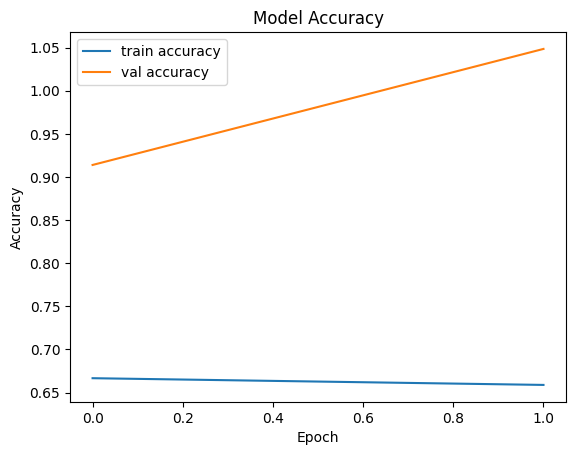

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

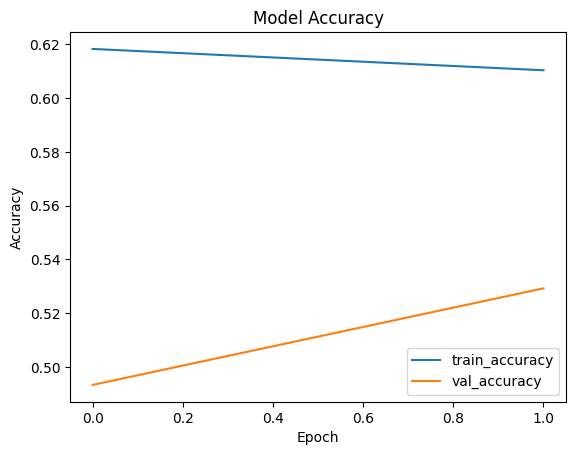

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and testing

In [113]:
test_dataset = test_dataset.batch(1)

In [114]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 27s 6ms/step - loss: 2.1891 - accuracy: 0.4937 - tp: 1361.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - fp: 1396.0000 - precision: 0.4937 - recall: 1.0000 - auc: 0.4581


[2.1890695095062256,
 0.4936525225639343,
 1361.0,
 0.0,
 0.0,
 1396.0,
 0.4936525225639343,
 1.0,
 0.4580545723438263]

In [115]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

In [116]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 10s 10s/step


'U'

1/1 [==============================] - 0s 21ms/step


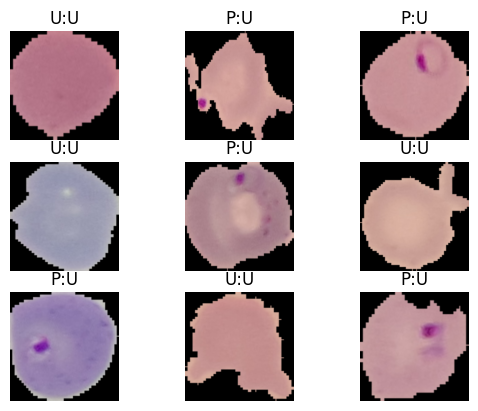

In [117]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')